In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pywt
import pywt.data

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize to [-1, 1]
])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
subset_size = 10_000
indices = np.random.choice(len(trainset), subset_size, replace=False)
train_subset = Subset(trainset, indices)
trainloader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
images, labels = next(iter(trainloader))
print(f"Subset size: {len(train_subset)}")
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

100%|██████████| 170M/170M [00:22<00:00, 7.62MB/s]


Subset size: 10000
Image batch shape: torch.Size([64, 3, 32, 32])
Label batch shape: torch.Size([64])


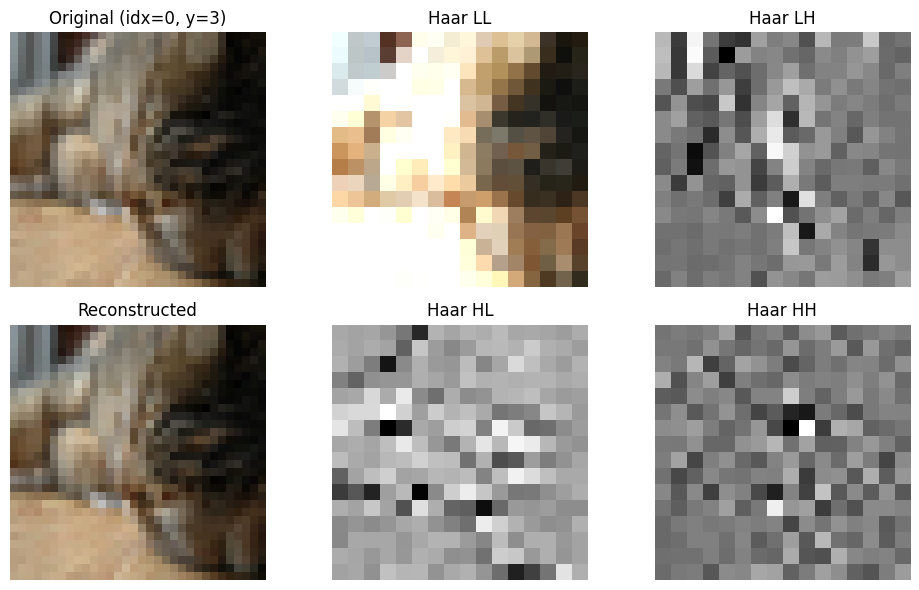

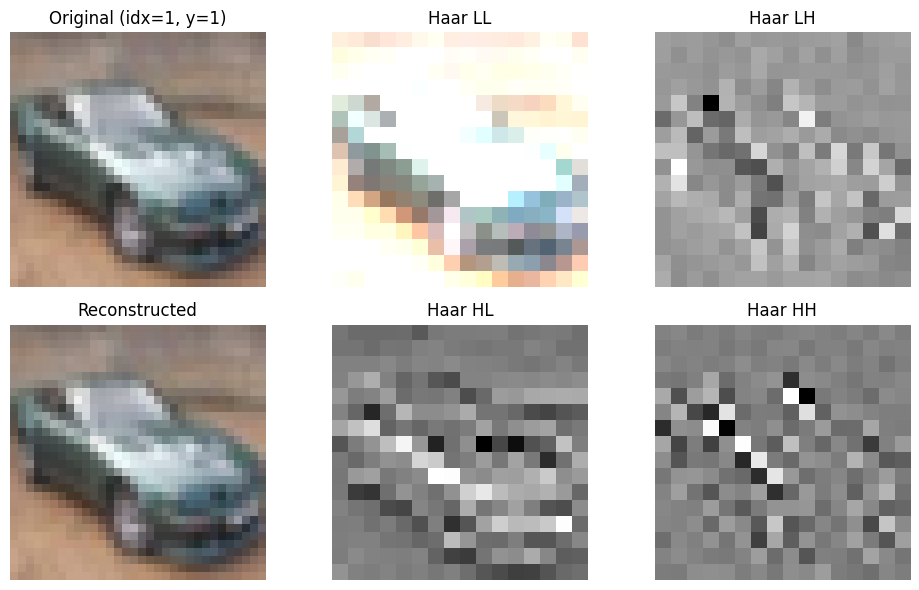

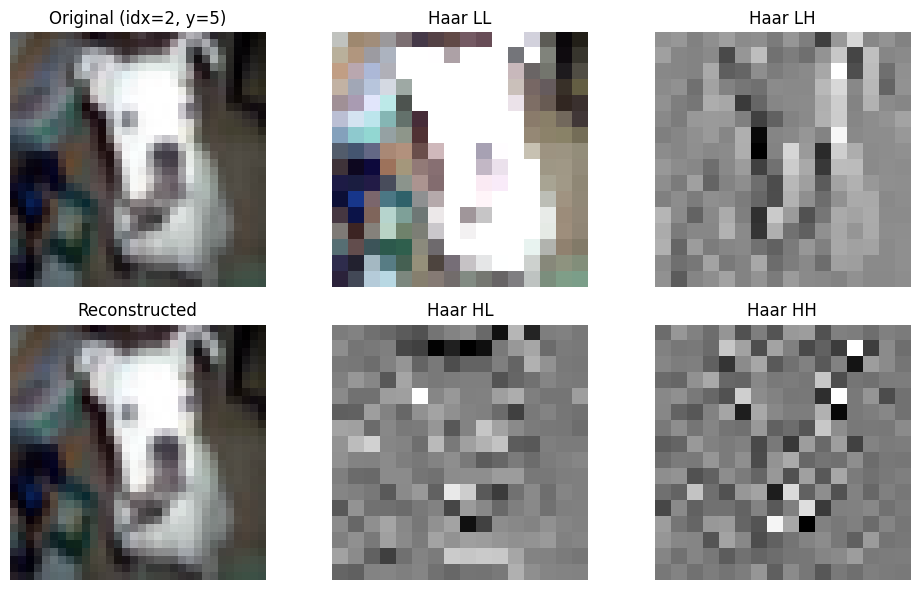

In [4]:
# This cell loads 10,000 CIFAR-10 samples, applies a 1-level Haar DWT,
# reconstructs the image via inverse DWT, and visualizes a few examples
# in a 2x3 grid: (top) Original, LL, LH ; (bottom) Reconstructed, HL, HH.
#
# DB2 via PyWavelets is optional—set TRY_DB2 to True if pywt is installed.
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Subset

# ----------------------
# Config
# ----------------------
N_SAMPLES = 10_000
SAMPLE_INDICES = [0, 1, 2]  # which samples from the subset to visualize
TRY_DB2 = False             # set True to also try DB2 (requires pywt)

# ----------------------
# Data: CIFAR-10 subset
# ----------------------
transform = transforms.ToTensor()  # keep in [0,1] for visualization
train_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
idxs = np.random.choice(len(train_full), N_SAMPLES, replace=False)
train = Subset(train_full, idxs)

def get_item(i):
    x, y = train[i]
    return x, y  # x: (3,32,32)

# ----------------------
# Haar DWT (analysis) and inverse (synthesis)
# ----------------------
s = 1.0 / np.sqrt(2.0)

def haar_dwt2(img):
    """
    1-level separable Haar DWT.
    img: (C,H,W), H and W even.
    Returns: LL, LH, HL, HH each (C, H/2, W/2).
    """
    C, H, W = img.shape
    assert H % 2 == 0 and W % 2 == 0, "Image dims must be even."

    def down_cols(x):
        # along width dim=2: even/odd columns
        even = x[:, :, ::2]
        odd  = x[:, :, 1::2]
        low  = s * (even + odd)
        high = s * (even - odd)
        return low, high  # (C,H,W/2) each

    def down_rows(x):
        # along height dim=1: even/odd rows
        even = x[:, ::2, :]
        odd  = x[:, 1::2, :]
        low  = s * (even + odd)
        high = s * (even - odd)
        return low, high  # (C,H/2,W) each

    # First: columns, then rows (either order works if consistent with inverse)
    low_c, high_c = down_cols(img)        # (C,H,W/2) each
    LL, HL = down_rows(low_c)             # LL from low, HL from low-high (rows)
    LH, HH = down_rows(high_c)            # LH from high-low (rows), HH from high-high (rows)
    return LL, LH, HL, HH

def inv1d_upsample(low, high, dim):
    """
    Inverse of the pairwise Haar along a single dimension using:
      even = (low + high) / sqrt(2)
      odd  = (low - high) / sqrt(2)
    Concatenate interleaving even/odd to double the size along 'dim'.
    """
    # permute so target dim is last
    if dim != -1:
        perm = list(range(low.dim()))
        perm[dim], perm[-1] = perm[-1], perm[dim]
        low  = low.permute(*perm)
        high = high.permute(*perm)

    even = (low + high) / np.sqrt(2.0)  # (..., N)
    odd  = (low - high) / np.sqrt(2.0)  # (..., N)

    N = even.shape[-1]
    out_shape = list(even.shape[:-1]) + [2 * N]
    out = even.new_zeros(out_shape)

    out[..., ::2] = even
    out[..., 1::2] = odd

    # permute back
    if dim != -1:
        inv_perm = list(range(out.dim()))
        inv_perm[dim], inv_perm[-1] = inv_perm[-1], inv_perm[dim]
        out = out.permute(*inv_perm)

    return out

def haar_idwt2(LL, LH, HL, HH):
    """
    Inverse 1-level separable Haar DWT.
    Inputs: (C, H/2, W/2). Output: (C, H, W).
    """
    # First invert rows to get low_c and high_c (C,H,W/2)
    low_c  = inv1d_upsample(LL, HL, dim=1)  # along rows (height)
    high_c = inv1d_upsample(LH, HH, dim=1)

    # Then invert columns to get original (C,H,W)
    img = inv1d_upsample(low_c, high_c, dim=2)  # along cols (width)
    return img

# Optional DB2 via PyWavelets
def db2_dwt2(img):
    import pywt
    LLs, LHs, HLs, HHs = [], [], [], []
    for c in range(img.shape[0]):
        arr = img[c].cpu().numpy()
        LL, (LH, HL, HH) = pywt.dwt2(arr, "db2", mode="periodization")
        LLs.append(torch.from_numpy(LL))
        LHs.append(torch.from_numpy(LH))
        HLs.append(torch.from_numpy(HL))
        HHs.append(torch.from_numpy(HH))
    return torch.stack(LLs), torch.stack(LHs), torch.stack(HLs), torch.stack(HHs)

def db2_idwt2(LL, LH, HL, HH):
    import pywt
    chans = []
    for c in range(LL.shape[0]):
        rec = pywt.idwt2((LL[c].numpy(),
                          (LH[c].numpy(), HL[c].numpy(), HH[c].numpy())),
                         "db2", mode="periodization")
        chans.append(torch.from_numpy(rec))
    return torch.stack(chans)

# ----------------------
# Helpers for plotting
# ----------------------
def chw_to_hwc(img):
    x = img.detach().cpu()
    x = x.clamp(0, 1)
    return x.permute(1, 2, 0).numpy()

def to_gray01(x):
    # average across channels, normalize to [0,1] for display
    g = x.mean(0)
    g = g - g.min()
    denom = g.max() - g.min()
    if denom > 1e-12:
        g = g / denom
    return g.numpy()

def plot_grid_original_wavelets_recon(img, LL, LH, HL, HH, recon, title_prefix="Haar", idx=0, label=None):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))

    # Top row: Original, LL (upsampled to 32x32 for viewing), LH
    axes[0,0].imshow(chw_to_hwc(img)); axes[0,0].set_title(f"Original (idx={idx}, y={label})"); axes[0,0].axis("off")

    LL_up = torch.nn.functional.interpolate(LL.unsqueeze(0), size=img.shape[1:], mode="nearest").squeeze(0)
    axes[0,1].imshow(chw_to_hwc(LL_up)); axes[0,1].set_title(f"{title_prefix} LL"); axes[0,1].axis("off")

    axes[0,2].imshow(to_gray01(LH), cmap="gray"); axes[0,2].set_title(f"{title_prefix} LH"); axes[0,2].axis("off")

    # Bottom row: Reconstructed, HL, HH
    axes[1,0].imshow(chw_to_hwc(recon)); axes[1,0].set_title("Reconstructed"); axes[1,0].axis("off")
    axes[1,1].imshow(to_gray01(HL), cmap="gray"); axes[1,1].set_title(f"{title_prefix} HL"); axes[1,1].axis("off")
    axes[1,2].imshow(to_gray01(HH), cmap="gray"); axes[1,2].set_title(f"{title_prefix} HH"); axes[1,2].axis("off")

    plt.tight_layout()
    plt.show()

# ----------------------
# Run a few visualizations
# ----------------------
for i in SAMPLE_INDICES:
    img, y = get_item(i)  # (3,32,32)

    # Haar forward + inverse
    LL, LH, HL, HH = haar_dwt2(img)
    recon = haar_idwt2(LL, LH, HL, HH).clamp(0,1)

    plot_grid_original_wavelets_recon(img, LL, LH, HL, HH, recon, title_prefix="Haar", idx=i, label=y)

    if TRY_DB2:
        try:
            LL2, LH2, HL2, HH2 = db2_dwt2(img)
            recon2 = db2_idwt2(LL2, LH2, HL2, HH2).clamp(0,1)
            plot_grid_original_wavelets_recon(img, LL2, LH2, HL2, HH2, recon2, title_prefix="DB2", idx=i, label=y)
        except Exception as e:
            print("DB2 (pywt) not available or failed:", e)


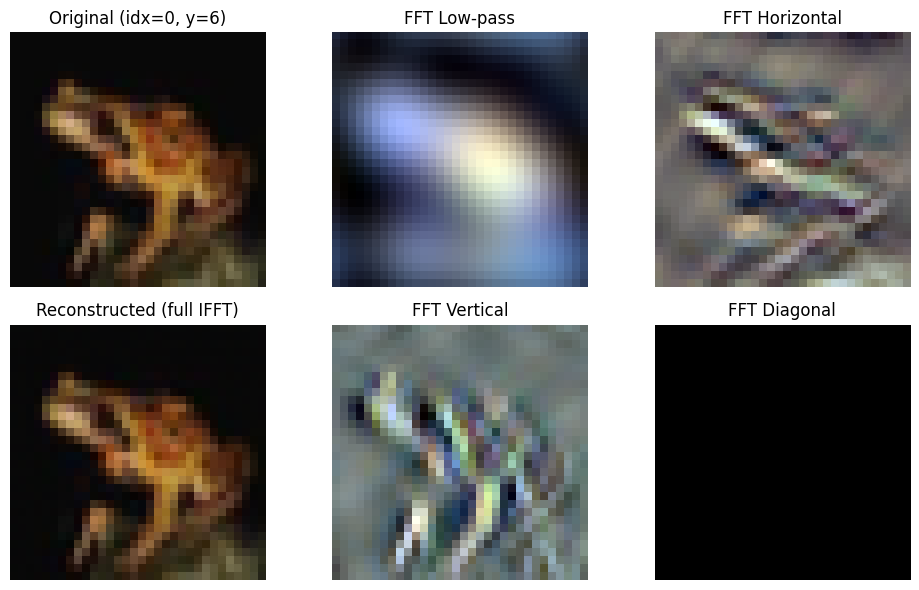

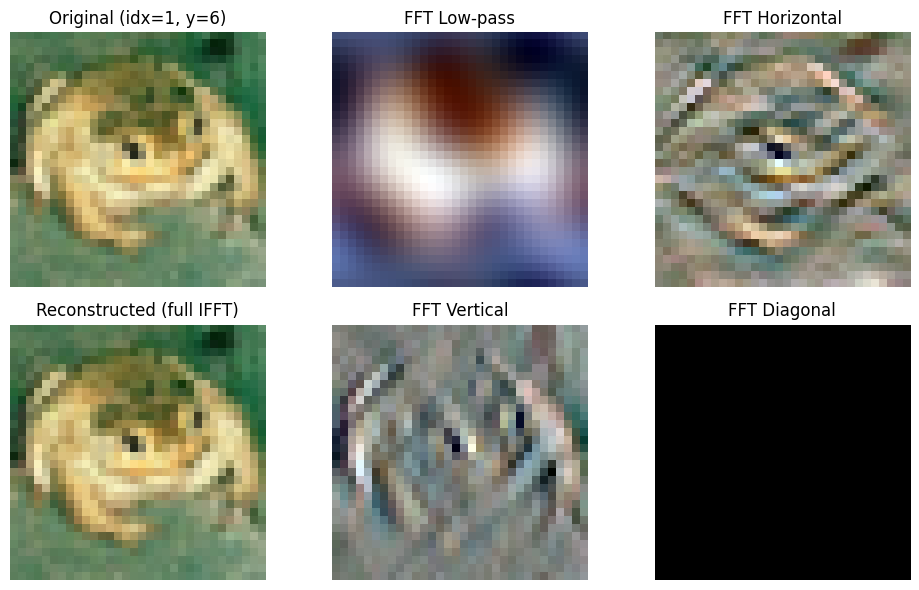

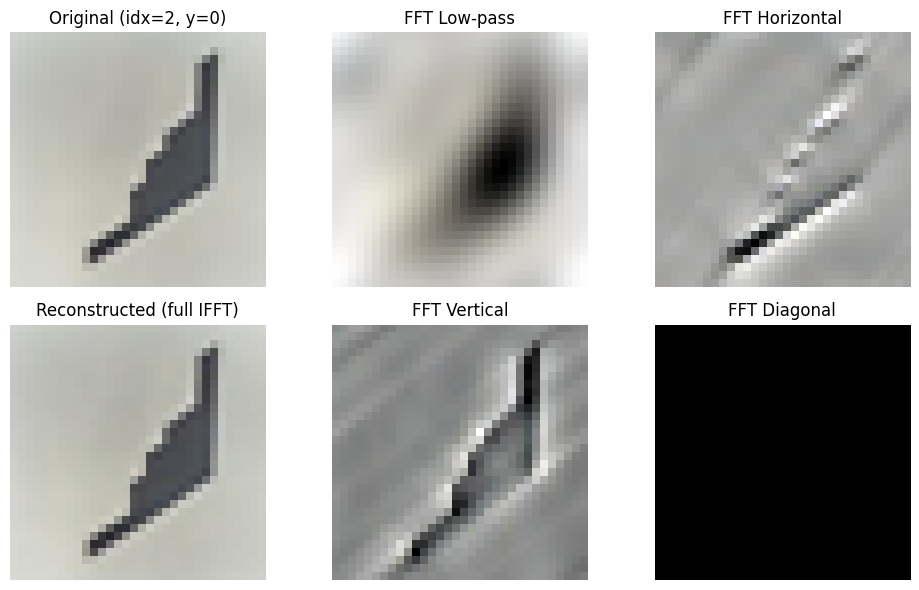

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset

# ----------------------------
# 0) Load 10k CIFAR-10 subset
# ----------------------------
def load_cifar10_subset(n_samples=10_000, root="./data"):
    from torchvision import datasets, transforms  # needs torchvision in your env
    tfm = transforms.ToTensor()  # keep [0,1] for display
    ds = datasets.CIFAR10(root=root, train=True, download=True, transform=tfm)
    idxs = np.random.choice(len(ds), n_samples, replace=False)
    return Subset(ds, idxs)

dataset = load_cifar10_subset()
SAMPLE_INDICES = [0, 1, 2]  # change as you like

def get_item(i):
    return dataset[i]  # (C,H,W), label

# -----------------------------------
# 1) 2D FFT helpers (per RGB channel)
# -----------------------------------
def fft2c(x):
    """Centered 2D FFT per-channel. x: (C,H,W) in float32."""
    X = torch.fft.fft2(x, dim=(-2, -1))
    return torch.fft.fftshift(X, dim=(-2, -1))

def ifft2c(X):
    """Inverse of fft2c."""
    x = torch.fft.ifftshift(X, dim=(-2, -1))
    x = torch.fft.ifft2(x, dim=(-2, -1))
    return x.real  # drop negligible imag

# -----------------------------------
# 2) Frequency masks (LP / H / V / D)
# -----------------------------------
def frequency_masks(h, w, lp_radius=500, hv_split=1000):
    """
    Create 4 masks on the normalized frequency plane:
      - LP: r <= lp_radius
      - H:  r > lp_radius and |v| >= hv_split*max(|u|,|v|)  (horizontal edges)
      - V:  r > lp_radius and |u| >= hv_split*max(|u|,|v|)  (vertical edges)
      - D:  remaining high-frequency (diagonals)
    u,v in [-1,1] roughly (normalized).
    """
    # meshgrid with origin at center, normalized to [-1,1]
    uu = (torch.arange(w) - (w-1)/2) / ((w-1)/2)
    vv = (torch.arange(h) - (h-1)/2) / ((h-1)/2)
    U, V = torch.meshgrid(uu, vv, indexing="xy")
    U = U.float(); V = V.float()
    R = torch.sqrt(U**2 + V**2)

    LP = (R <= lp_radius)

    # define dominance via max(|u|,|v|)
    M = torch.maximum(U.abs(), V.abs()) + 1e-8
    H = (R > lp_radius) & (V.abs() >= hv_split * M)           # horizontal edges (high vertical freq)
    Vmask = (R > lp_radius) & (U.abs() >= hv_split * M)       # vertical edges (high horizontal freq)
    D = (R > lp_radius) & (~H) & (~Vmask)                     # diagonals

    # expand to (1,H,W) so it can broadcast over channels
    LP = LP.unsqueeze(0)
    H  = H.unsqueeze(0)
    Vmask = Vmask.unsqueeze(0)
    D  = D.unsqueeze(0)
    return LP, H, Vmask, D

# -----------------------------------
# 3) Apply mask component -> spatial
# -----------------------------------
def component_ifft(img, mask):
    """
    img: (C,H,W) in [0,1]
    mask: (1,H,W) boolean/float
    return: (C,H,W) real image reconstructed from masked spectrum
    """
    X = fft2c(img)
    X_masked = X * mask.to(X.dtype)
    x_comp = ifft2c(X_masked)
    # For visualization, rescale to [0,1] per-channel (robust)
    x = x_comp.clone()
    for c in range(x.shape[0]):
        mn = x[c].min()
        mx = x[c].max()
        if (mx - mn) > 1e-12:
            x[c] = (x[c] - mn) / (mx - mn)
        else:
            x[c] = torch.zeros_like(x[c])
    return x.clamp(0, 1)

# -----------------------------------
# 4) Plotting (2×3 grid as requested)
# -----------------------------------
def chw_to_hwc(x):
    return x.detach().cpu().permute(1,2,0).numpy()

def plot_fft_components(img, lp_img, h_img, v_img, d_img, recon, idx, label):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))

    # Top row: Original, Low-pass, Horizontal
    axes[0,0].imshow(chw_to_hwc(img));      axes[0,0].set_title(f"Original (idx={idx}, y={label})"); axes[0,0].axis("off")
    axes[0,1].imshow(chw_to_hwc(lp_img));   axes[0,1].set_title("FFT Low-pass");                      axes[0,1].axis("off")
    axes[0,2].imshow(chw_to_hwc(h_img));    axes[0,2].set_title("FFT Horizontal");                    axes[0,2].axis("off")

    # Bottom row: Reconstructed (full IFFT), Vertical, Diagonal
    axes[1,0].imshow(chw_to_hwc(recon));    axes[1,0].set_title("Reconstructed (full IFFT)");         axes[1,0].axis("off")
    axes[1,1].imshow(chw_to_hwc(v_img));    axes[1,1].set_title("FFT Vertical");                      axes[1,1].axis("off")
    axes[1,2].imshow(chw_to_hwc(d_img));    axes[1,2].set_title("FFT Diagonal");                      axes[1,2].axis("off")

    plt.tight_layout()
    plt.show()

# -----------------------------------
# 5) Run a few examples
# -----------------------------------
for i in SAMPLE_INDICES:
    x, y = get_item(i)                # x: (3,32,32) in [0,1]
    C, H, W = x.shape
    LP, Hmask, Vmask, Dmask = frequency_masks(H, W, lp_radius=0.18, hv_split=0.75)

    # Full reconstruction (IFFT of the full spectrum) should match x (up to fp error)
    X_full = fft2c(x)
    x_recon = ifft2c(X_full).clamp(0, 1)

    # Components reconstructed from masked spectra
    x_lp = component_ifft(x, LP)
    x_h  = component_ifft(x, Hmask)
    x_v  = component_ifft(x, Vmask)
    x_d  = component_ifft(x, Dmask)

    plot_fft_components(x, x_lp, x_h, x_v, x_d, x_recon, idx=i, label=y)


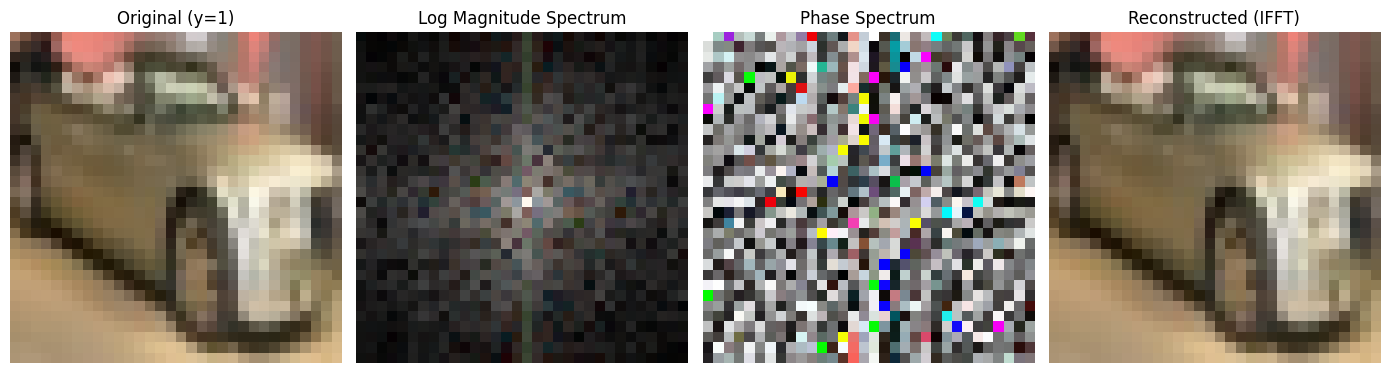

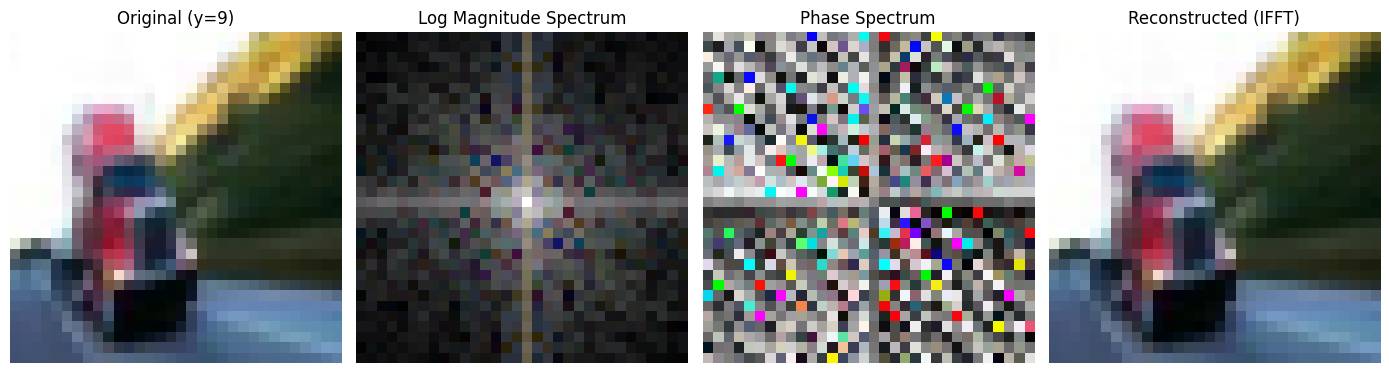

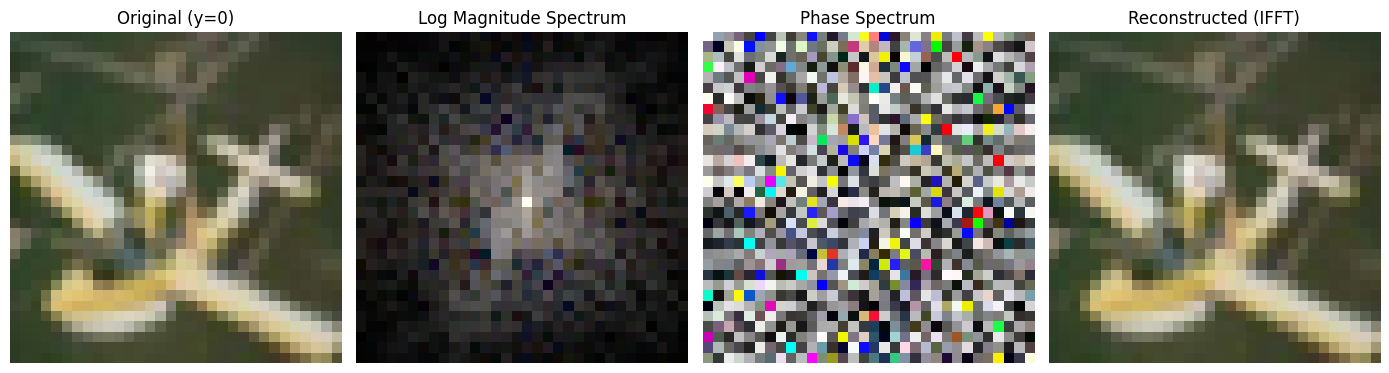

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Subset

# ------------------------------
# 1. Load subset of CIFAR-10
# ------------------------------
transform = transforms.ToTensor()
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
subset = Subset(dataset, np.random.choice(len(dataset), 10_000, replace=False))

def get_item(i):
    return subset[i]  # (C,H,W), label

# ------------------------------
# 2. FFT utilities
# ------------------------------
def fft2_centered(x):
    """Compute centered 2D FFT per channel."""
    X = torch.fft.fft2(x, dim=(-2, -1))
    return torch.fft.fftshift(X, dim=(-2, -1))

def ifft2_centered(X):
    """Inverse of fft2_centered."""
    x = torch.fft.ifftshift(X, dim=(-2, -1))
    x = torch.fft.ifft2(x, dim=(-2, -1))
    return x.real  # ignore small imaginary part

def magnitude_spectrum(X):
    """Log magnitude spectrum for visualization."""
    mag = torch.log1p(torch.abs(X))
    mag = mag / mag.max()
    return mag

def phase_spectrum(X):
    """Phase spectrum normalized to [0,1] for display."""
    phase = torch.angle(X)
    phase = (phase + np.pi) / (2 * np.pi)
    return phase

def chw_to_hwc(x):
    return x.detach().cpu().permute(1, 2, 0).numpy()

# ------------------------------
# 3. Plot with reconstruction
# ------------------------------
SAMPLE_INDICES = [0, 1, 2]

for i in SAMPLE_INDICES:
    x, y = get_item(i)  # (3,32,32), label

    # Forward and inverse FFT
    X = fft2_centered(x)
    x_recon = ifft2_centered(X).clamp(0, 1)

    # Visualization components
    mag = magnitude_spectrum(X)
    phase = phase_spectrum(X)

    fig, axes = plt.subplots(1, 4, figsize=(14, 4))

    axes[0].imshow(chw_to_hwc(x))
    axes[0].set_title(f"Original (y={y})")
    axes[0].axis("off")

    axes[1].imshow(chw_to_hwc(mag), cmap="gray")
    axes[1].set_title("Log Magnitude Spectrum")
    axes[1].axis("off")

    axes[2].imshow(chw_to_hwc(phase), cmap="twilight")
    axes[2].set_title("Phase Spectrum")
    axes[2].axis("off")

    axes[3].imshow(chw_to_hwc(x_recon))
    axes[3].set_title("Reconstructed (IFFT)")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()


In [7]:
def add_salt_pepper_noise(imgs, prob=0.05):
    if imgs.dim() == 3:
        imgs = imgs.unsqueeze(0)
    noisy_imgs = imgs.clone()
    B, C, H, W = noisy_imgs.shape
    rand = torch.rand_like(noisy_imgs)
    noisy_imgs[rand < (prob / 2)] = 0.0      # pepper
    noisy_imgs[rand > 1 - (prob / 2)] = 1.0  # salt
    return noisy_imgs.squeeze(0) if imgs.shape[0] == 1 else noisy_imgs

In [8]:
for imgs, _ in trainloader:
    imgs = imgs.to('cpu')
    noisy_imgs = add_salt_pepper_noise(imgs, prob=0.05)

In [9]:
def fft_denoise(img, lp_radius=0.18):
    X = fft2_centered(img)
    h, w = img.shape[1:]
    LP, _, _, _ = frequency_masks(h, w, lp_radius=lp_radius)
    X_denoised = X * LP
    recon = ifft2_centered(X_denoised).clamp(0, 1)
    return recon



Epoch 1/20


  Wavelet Loss: 0.01844, Fourier Loss: 1.03724

Epoch 2/20


  Wavelet Loss: 0.00537, Fourier Loss: 0.34485

Epoch 3/20


  Wavelet Loss: 0.00504, Fourier Loss: 0.27421

Epoch 4/20


  Wavelet Loss: 0.00491, Fourier Loss: 0.25358

Epoch 5/20


  Wavelet Loss: 0.00494, Fourier Loss: 0.24527

Epoch 6/20


  Wavelet Loss: 0.00480, Fourier Loss: 0.23450

Epoch 7/20


  Wavelet Loss: 0.00477, Fourier Loss: 0.22699

Epoch 8/20


  Wavelet Loss: 0.00460, Fourier Loss: 0.21742

Epoch 9/20


  Wavelet Loss: 0.00484, Fourier Loss: 0.22392

Epoch 10/20


  Wavelet Loss: 0.00480, Fourier Loss: 0.21923

Epoch 11/20


  Wavelet Loss: 0.00474, Fourier Loss: 0.21333

Epoch 12/20


  Wavelet Loss: 0.00484, Fourier Loss: 0.21777

Epoch 13/20


  Wavelet Loss: 0.00476, Fourier Loss: 0.21413

Epoch 14/20


  Wavelet Loss: 0.00486, Fourier Loss: 0.21606

Epoch 15/20


  Wavelet Loss: 0.00453, Fourier Loss: 0.20197

Epoch 16/20


  Wavelet Loss: 0.00462, Fourier Loss: 0.20437

Epoch 17/20


  Wavelet Loss: 0.00461, Fourier Loss: 0.20446

Epoch 18/20


  Wavelet Loss: 0.00454, Fourier Loss: 0.20298

Epoch 19/20


  Wavelet Loss: 0.00451, Fourier Loss: 0.20142

Epoch 20/20


  Wavelet Loss: 0.00443, Fourier Loss: 0.19762
Noise std 0.05: Wavelet MSE=0.0013, Fourier MSE=0.0013


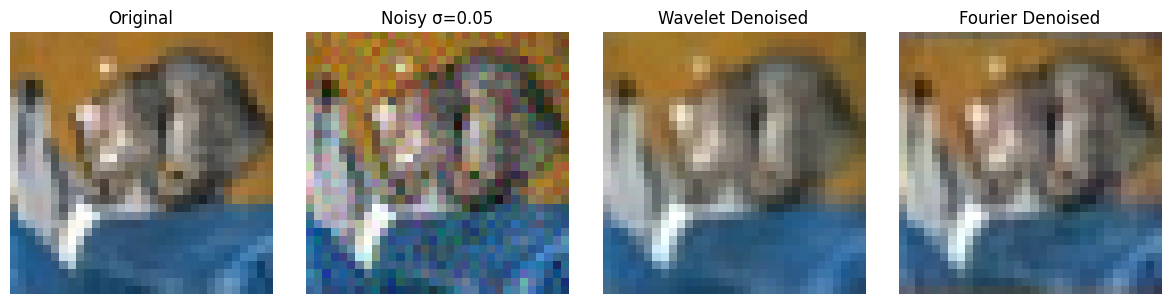

Noise std 0.10: Wavelet MSE=0.0020, Fourier MSE=0.0024


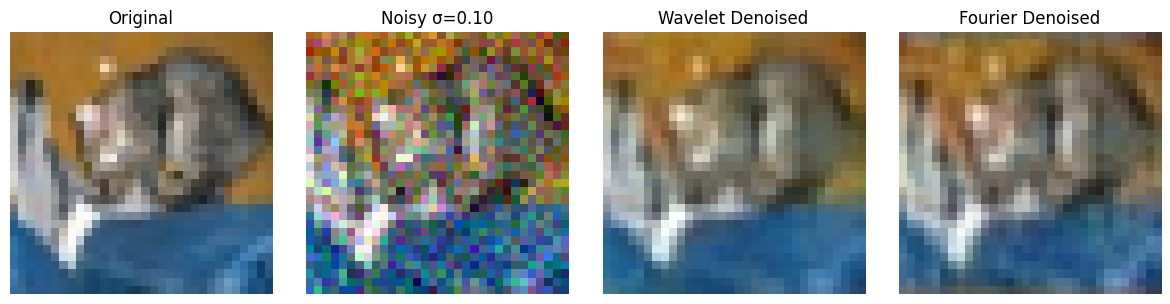

Noise std 0.15: Wavelet MSE=0.0030, Fourier MSE=0.0037


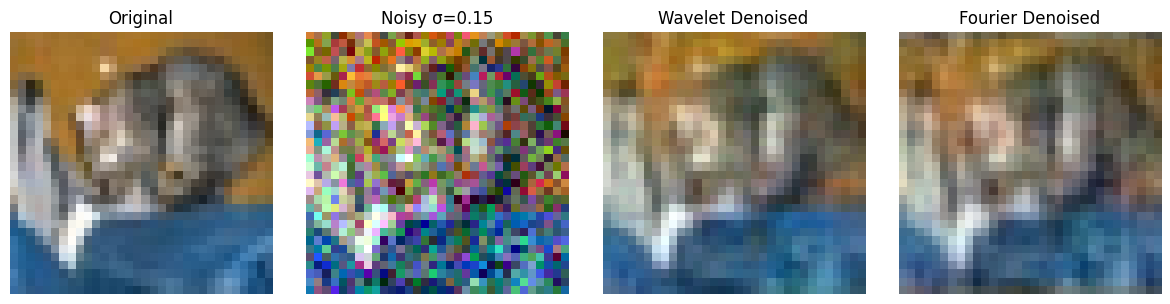

Noise std 0.20: Wavelet MSE=0.0044, Fourier MSE=0.0053


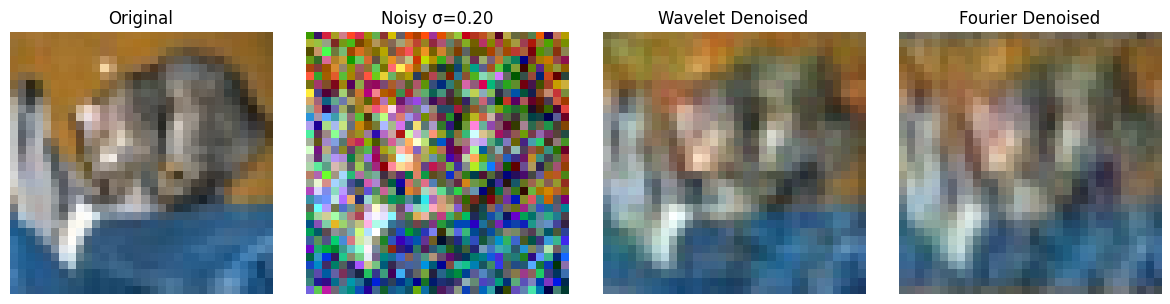

Noise std 0.25: Wavelet MSE=0.0061, Fourier MSE=0.0071


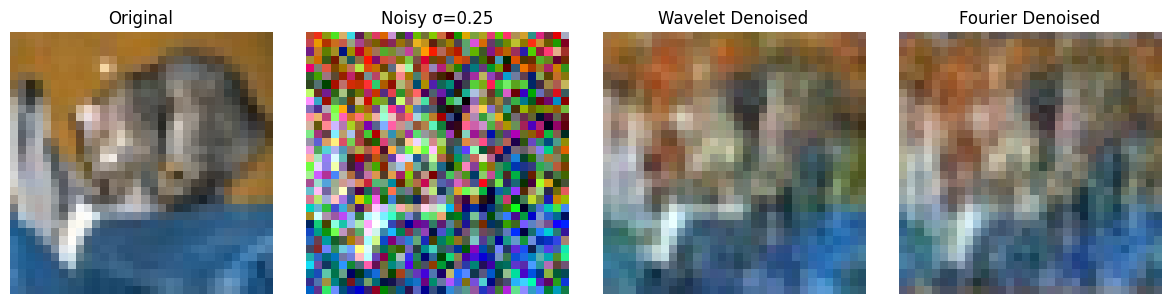

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
min_noise, max_noise = 0.05, 0.25  # Range of noise std during training
noise_levels_test = [0.05, 0.10, 0.15, 0.20, 0.25]  # Test on these sigmas

def frequency_masks(H, W, lp_radius=0.18, hv_split=0.75):
    """
    Build simple radial low-pass / high-pass masks for a centered FFT.
    Returns (LP, HP, VX, VY) but we only use LP here.
    """
    cy, cx = H // 2, W // 2
    y = torch.arange(H).float() - cy
    x = torch.arange(W).float() - cx
    Y, X = torch.meshgrid(y, x, indexing="ij")
    R = torch.sqrt(X**2 + Y**2)
    R_norm = R / R.max()  # 0..1

    LP = (R_norm <= lp_radius).float()
    HP = 1.0 - LP

    VX = (torch.abs(X) >= torch.abs(Y)).float()
    VY = 1.0 - VX
    return LP, HP, VX, VY
def classical_wavelet_denoise_batch(noisy_imgs, lam=0.08):
    """
    Simple classical Haar-wavelet denoiser on a batch: [B,3,H,W].
    We leave LL (approximation) untouched and soft-threshold LH/HL/HH.
    """
    # Haar DWT on noisy images
    LL, LH, HL, HH = haar_dwt2(noisy_imgs)

    def soft_thresh(x, lam_val):
        return torch.sign(x) * torch.relu(torch.abs(x) - lam_val)

    LH_d = soft_thresh(LH, lam)
    HL_d = soft_thresh(HL, lam)
    HH_d = soft_thresh(HH, lam)

    # Reconstruct and clamp to [0,1]
    recon = haar_idwt2(LL, LH_d, HL_d, HH_d).clamp(0.0, 1.0)
    return recon
def classical_fourier_denoise_batch(noisy_imgs, lp_radius=0.18):
    """
    Simple FFT low-pass denoiser on a batch: [B,3,H,W].
    Keeps low frequencies via the LP mask, zeroes the rest.
    """
    # Centered FFT on batch
    X = fft2c(noisy_imgs)  # shape [B,3,H,W], complex
    B, C, H, W = X.shape

    # Get low-pass mask (1,H,W), then expand to (1,1,H,W) to broadcast over B,C
    LP, _, _, _ = frequency_masks(H, W, lp_radius=lp_radius, hv_split=0.75)
    LP = LP.to(X.device).unsqueeze(0).to(X.dtype)  # (1,1,H,W)

    X_lp = X * LP  # broadcast: (B,3,H,W) * (1,1,H,W)
    recon = ifft2c(X_lp).clamp(0.0, 1.0)
    return recon

num_epochs = 20

# --- Data
transform = transforms.ToTensor()
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

# --- Noise Function
def add_gaussian_noise(imgs, std=0.15):
    noisy_imgs = imgs + torch.randn_like(imgs) * std
    return torch.clamp(noisy_imgs, 0, 1)

# --- Haar Wavelet Transform and Inverse
s = 1.0 / torch.sqrt(torch.tensor(2.0))
def haar_dwt2(img):
    even = img[:, :, :, ::2]
    odd  = img[:, :, :, 1::2]
    low  = s * (even + odd)
    high = s * (even - odd)
    even = low[:, :, ::2, :]
    odd  = low[:, :, 1::2, :]
    LL = s * (even + odd)
    HL = s * (even - odd)
    even = high[:, :, ::2, :]
    odd  = high[:, :, 1::2, :]
    LH = s * (even + odd)
    HH = s * (even - odd)
    return LL, LH, HL, HH

def inv1d_upsample(low, high, dim):
    even = (low + high) / torch.sqrt(torch.tensor(2.0))
    odd  = (low - high) / torch.sqrt(torch.tensor(2.0))
    N = even.shape[dim]
    out_shape = list(even.shape)
    out_shape[dim] = 2 * N
    out = torch.zeros(out_shape, device=low.device)
    idx = [slice(None)] * len(out_shape)
    idx[dim] = slice(0, None, 2)
    out[tuple(idx)] = even
    idx[dim] = slice(1, None, 2)
    out[tuple(idx)] = odd
    return out

def haar_idwt2(LL, LH, HL, HH):
    low_c  = inv1d_upsample(LL, HL, dim=2)
    high_c = inv1d_upsample(LH, HH, dim=2)
    img = inv1d_upsample(low_c, high_c, dim=3)
    return img

# --- FFT Transform
def fft2c(x):
    X = torch.fft.fft2(x, dim=(-2, -1))
    return torch.fft.fftshift(X, dim=(-2, -1))

def ifft2c(X):
    x = torch.fft.ifftshift(X, dim=(-2, -1))
    x = torch.fft.ifft2(x, dim=(-2, -1))
    return x.real
def gradient_loss(pred, target):
    sobel_x = torch.tensor([[1, 0, -1],
                            [2, 0, -2],
                            [1, 0, -1]], dtype=torch.float32, device=pred.device).unsqueeze(0).unsqueeze(0)
    sobel_y = torch.tensor([[1, 2, 1],
                            [0, 0, 0],
                            [-1, -2, -1]], dtype=torch.float32, device=pred.device).unsqueeze(0).unsqueeze(0)

    # Compute gradients per channel and sum
    grad_loss = 0.0
    for c in range(pred.shape[1]):  # Iterate over channels (usually 3)
        grad_pred_x = torch.nn.functional.conv2d(pred[:, c:c+1], sobel_x, padding=1)
        grad_pred_y = torch.nn.functional.conv2d(pred[:, c:c+1], sobel_y, padding=1)
        grad_target_x = torch.nn.functional.conv2d(target[:, c:c+1], sobel_x, padding=1)
        grad_target_y = torch.nn.functional.conv2d(target[:, c:c+1], sobel_y, padding=1)

        grad_diff_x = torch.mean((grad_pred_x - grad_target_x) ** 2)
        grad_diff_y = torch.mean((grad_pred_y - grad_target_y) ** 2)
        grad_loss += grad_diff_x + grad_diff_y

    return grad_loss / pred.shape[1]  # Average over channels


# --- Wavelet Denoising CNN
class WaveletCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(12, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 12, 3, padding=1)
        )
    def forward(self, x):
        return self.net(x)

# --- Fourier Denoising CNN
class FourierCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(6, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 6, 3, padding=1)
        )
    def forward(self, x):
        return self.net(x)

# --- Prepare Models and Optimizers
wavelet_model = WaveletCNN().to(device)
fourier_model = FourierCNN().to(device)
optimizer_wavelet = optim.Adam(wavelet_model.parameters(), lr=1e-3)
optimizer_fourier = optim.Adam(fourier_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

alpha_coef    = 0.1   # weight for subband (coefficient) loss
gamma_teacher = 0.1   # weight for teacher distillation loss

# --- Training Loop: Blind Denoising (variable noise)
for epoch in range(num_epochs):
    wavelet_model.train()
    fourier_model.train()
    wavelet_losses = []
    fourier_losses = []

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    for imgs, _ in tqdm(trainloader, desc=f"Training Epoch {epoch+1}", leave=False):
        imgs = imgs.to(device)
        std = np.random.uniform(min_noise, max_noise)
        noisy_imgs = add_gaussian_noise(imgs, std=std)

        # --- Wavelet Pipeline ---
        LL, LH, HL, HH = haar_dwt2(noisy_imgs)
        wavelet_input = torch.cat([LL, LH, HL, HH], dim=1)

        LL_gt, LH_gt, HL_gt, HH_gt = haar_dwt2(imgs)
        wavelet_target = torch.cat([LL_gt, LH_gt, HL_gt, HH_gt], dim=1)

        wavelet_out = wavelet_model(wavelet_input)
        LL_out, LH_out, HL_out, HH_out = torch.split(wavelet_out, 3, dim=1)
        recon_wavelet = haar_idwt2(LL_out, LH_out, HL_out, HH_out).clamp(0.0, 1.0)

        # 1) image-domain MSE
        img_loss_wav = criterion(recon_wavelet, imgs)

        # 2) subband / coefficient-domain MSE
        coef_loss_wav = torch.nn.functional.mse_loss(wavelet_out, wavelet_target)

        # 3) teacher distillation loss (classical wavelet denoiser)
        with torch.no_grad():
            teacher_wav = classical_wavelet_denoise_batch(noisy_imgs)
        teacher_loss_wav = criterion(recon_wavelet, teacher_wav)

        loss_wavelet = (
            img_loss_wav
            + alpha_coef    * coef_loss_wav
            + gamma_teacher * teacher_loss_wav
            # + 0.0 * gradient_loss(recon_wavelet, imgs)  # keep off for now if you want
        )

        optimizer_wavelet.zero_grad()
        loss_wavelet.backward()
        optimizer_wavelet.step()
        wavelet_losses.append(loss_wavelet.item())


        # --- Fourier Pipeline ---
        X = fft2c(noisy_imgs)
        fourier_input = torch.cat([X.real, X.imag], dim=1)

        X_gt = fft2c(imgs)
        fourier_target = torch.cat([X_gt.real, X_gt.imag], dim=1)

        fourier_out = fourier_model(fourier_input)
        X_out = torch.complex(fourier_out[:, :3], fourier_out[:, 3:])
        recon_fourier = ifft2c(X_out).clamp(0.0, 1.0)

        # 1) image-domain MSE
        img_loss_fft = criterion(recon_fourier, imgs)

        # 2) coefficient-domain MSE in Fourier domain (real+imag stacked)
        coef_loss_fft = torch.nn.functional.mse_loss(fourier_out, fourier_target)

        # 3) teacher distillation loss (classical low-pass FFT denoiser)
        with torch.no_grad():
            teacher_fft = classical_fourier_denoise_batch(noisy_imgs)
        teacher_loss_fft = criterion(recon_fourier, teacher_fft)

        loss_fourier = (
            img_loss_fft
            + alpha_coef    * coef_loss_fft
            + gamma_teacher * teacher_loss_fft
            # + 0.0 * gradient_loss(recon_fourier, imgs)
        )

        optimizer_fourier.zero_grad()
        loss_fourier.backward()
        optimizer_fourier.step()
        fourier_losses.append(loss_fourier.item())


    print(f"  Wavelet Loss: {np.mean(wavelet_losses):.5f}, Fourier Loss: {np.mean(fourier_losses):.5f}")

# --- Robustness Test + Visualization ---
wavelet_model.eval()
fourier_model.eval()
for std in noise_levels_test:
    imgs, _ = next(iter(testloader))
    imgs = imgs.to(device)
    noisy_imgs = add_gaussian_noise(imgs, std=std)
    with torch.no_grad():
        # Wavelet prediction
        LL, LH, HL, HH = haar_dwt2(noisy_imgs)
        wavelet_input = torch.cat([LL, LH, HL, HH], dim=1)
        wavelet_out = wavelet_model(wavelet_input)
        LL_out, LH_out, HL_out, HH_out = torch.split(wavelet_out, 3, dim=1)
        recon_wavelet = haar_idwt2(LL_out, LH_out, HL_out, HH_out).clamp(0, 1)
        # Fourier prediction
        X = fft2c(noisy_imgs)
        fourier_input = torch.cat([X.real, X.imag], dim=1)
        fourier_out = fourier_model(fourier_input)
        X_out = torch.complex(fourier_out[:, :3], fourier_out[:, 3:])
        recon_fourier = ifft2c(X_out).clamp(0, 1)

    # Compute and print quantitative MSE
    wavelet_mse = nn.functional.mse_loss(recon_wavelet, imgs).item()
    fourier_mse = nn.functional.mse_loss(recon_fourier, imgs).item()
    print(f"Noise std {std:.2f}: Wavelet MSE={wavelet_mse:.4f}, Fourier MSE={fourier_mse:.4f}")

    # Visualize outputs (show first image in batch)
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    axes[0].imshow(imgs[0].cpu().permute(1,2,0)); axes[0].set_title("Original"); axes[0].axis("off")
    axes[1].imshow(noisy_imgs[0].cpu().permute(1,2,0)); axes[1].set_title(f"Noisy σ={std:.2f}"); axes[1].axis("off")
    axes[2].imshow(recon_wavelet[0].cpu().permute(1,2,0)); axes[2].set_title("Wavelet Denoised"); axes[2].axis("off")
    axes[3].imshow(recon_fourier[0].cpu().permute(1,2,0)); axes[3].set_title("Fourier Denoised"); axes[3].axis("off")
    plt.tight_layout(); plt.show()


Noise std 0.05: Wavelet MSE=0.0013, Fourier MSE=0.0013


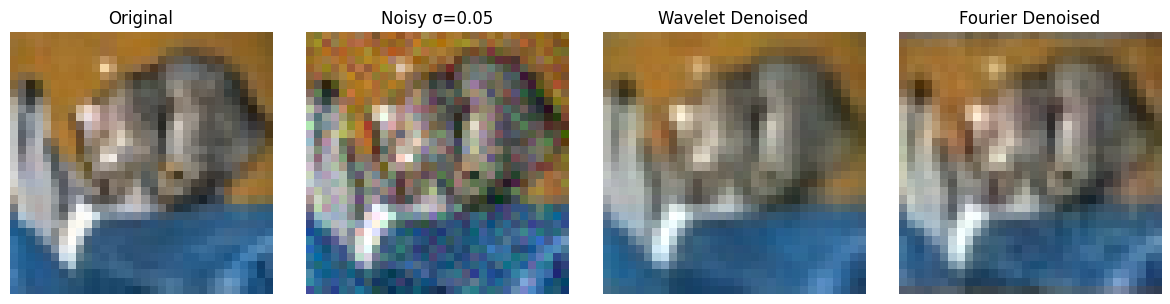

Noise std 0.10: Wavelet MSE=0.0020, Fourier MSE=0.0023


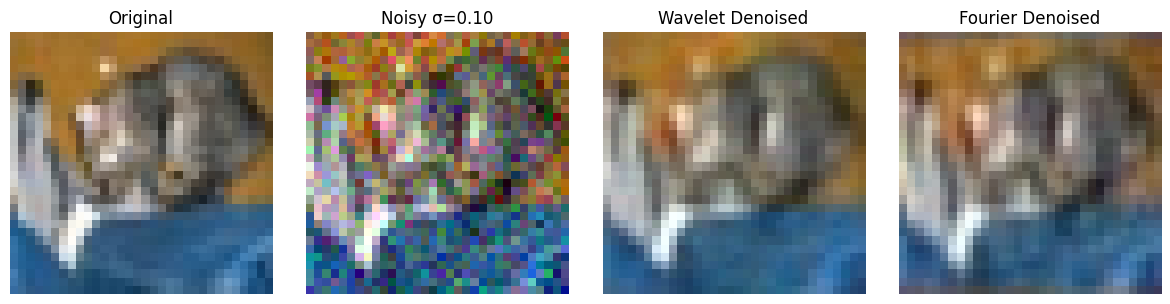

Noise std 0.15: Wavelet MSE=0.0030, Fourier MSE=0.0037


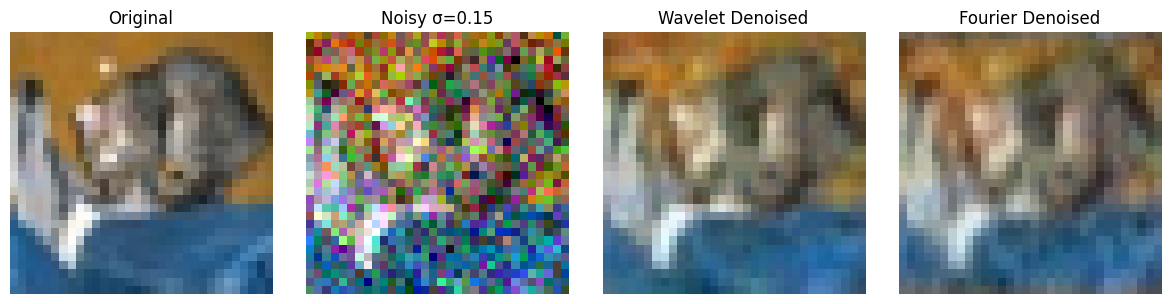

Noise std 0.20: Wavelet MSE=0.0044, Fourier MSE=0.0053


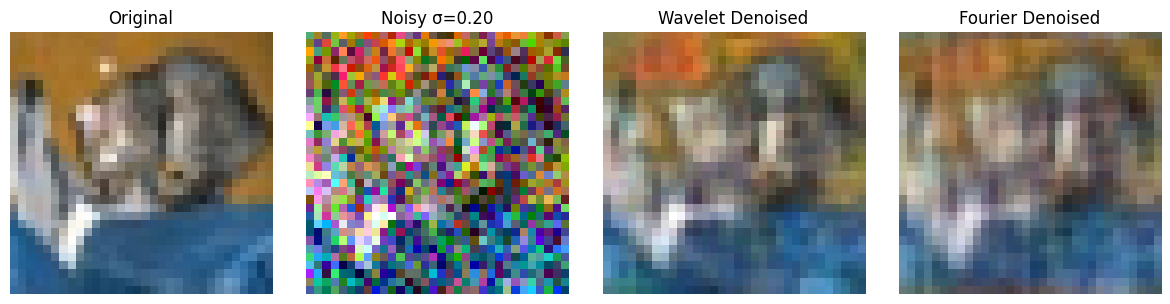

Noise std 0.25: Wavelet MSE=0.0061, Fourier MSE=0.0070


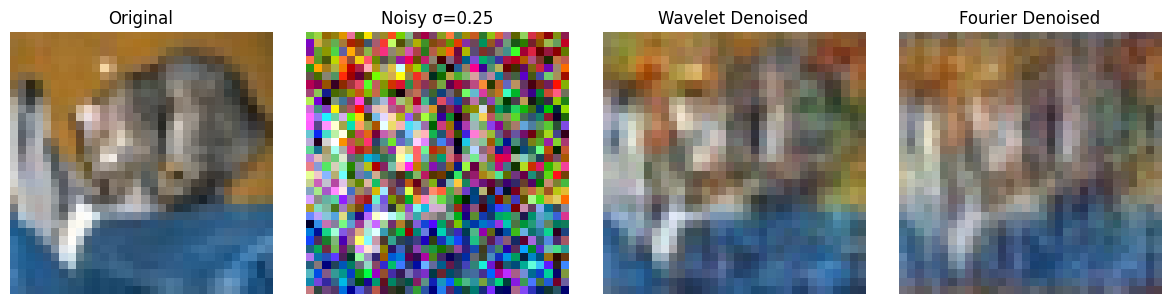

In [11]:
noise_levels = [0.05, 0.10, 0.15, 0.20, 0.25]
wavelet_model.eval()
fourier_model.eval()

for std in noise_levels:
    imgs, _ = next(iter(testloader))
    imgs = imgs.to(device)
    noisy_imgs = add_gaussian_noise(imgs, std=std)
    with torch.no_grad():
        LL, LH, HL, HH = haar_dwt2(noisy_imgs)
        wavelet_input = torch.cat([LL, LH, HL, HH], dim=1)
        wavelet_out = wavelet_model(wavelet_input)
        LL_out, LH_out, HL_out, HH_out = torch.split(wavelet_out, 3, dim=1)
        recon_wavelet = haar_idwt2(LL_out, LH_out, HL_out, HH_out).clamp(0, 1)
        X = fft2c(noisy_imgs)
        fourier_input = torch.cat([X.real, X.imag], dim=1)
        fourier_out = fourier_model(fourier_input)
        X_out = torch.complex(fourier_out[:, :3], fourier_out[:, 3:])
        recon_fourier = ifft2c(X_out).clamp(0, 1)

    wavelet_mse = nn.functional.mse_loss(recon_wavelet, imgs).item()
    fourier_mse = nn.functional.mse_loss(recon_fourier, imgs).item()
    print(f"Noise std {std:.2f}: Wavelet MSE={wavelet_mse:.4f}, Fourier MSE={fourier_mse:.4f}")

    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    axes[0].imshow(imgs[0].cpu().permute(1,2,0)); axes[0].set_title("Original"); axes[0].axis("off")
    axes[1].imshow(noisy_imgs[0].cpu().permute(1,2,0)); axes[1].set_title(f"Noisy σ={std:.2f}"); axes[1].axis("off")
    axes[2].imshow(recon_wavelet[0].cpu().permute(1,2,0)); axes[2].set_title("Wavelet Denoised"); axes[2].axis("off")
    axes[3].imshow(recon_fourier[0].cpu().permute(1,2,0)); axes[3].set_title("Fourier Denoised"); axes[3].axis("off")
    plt.tight_layout(); plt.show()


In [12]:
import torch
import torch.nn as nn
import math
from tqdm import tqdm

def psnr(mse, max_val=1.0):
    if mse == 0:
        return float('inf')
    return 10.0 * math.log10((max_val * max_val) / mse)

@torch.no_grad()
def evaluate_denoisers(
    wavelet_model,
    fourier_model,
    testloader,
    device,
    noise_levels=(0.05, 0.10, 0.15, 0.20, 0.25),
    show_examples=False,
    example_batches=5
):
    wavelet_model.eval()
    fourier_model.eval()

    for std in noise_levels:
        # Make results reproducible per-noise-level
        torch.manual_seed(1234 + int(std * 100))
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(1234 + int(std * 100))

        wavelet_mse_sum = 0.0
        fourier_mse_sum = 0.0
        n_pixels = 0

        example_plotted = 0

        for imgs, _ in tqdm(testloader, desc=f"σ={std:.2f}"):
            imgs = imgs.to(device)
            noisy = add_gaussian_noise(imgs, std=std).to(device)

            LL, LH, HL, HH = haar_dwt2(noisy)
            wavelet_in = torch.cat([LL, LH, HL, HH], dim=1)
            wavelet_out = wavelet_model(wavelet_in)
            LL_out, LH_out, HL_out, HH_out = torch.split(wavelet_out, 3, dim=1)
            recon_wav = haar_idwt2(LL_out, LH_out, HL_out, HH_out).clamp(0, 1)

            X = fft2c(noisy)
            fourier_in = torch.cat([X.real, X.imag], dim=1)
            fourier_out = fourier_model(fourier_in)
            xr, xi = fourier_out[:, :3], fourier_out[:, 3:]
            X_out = torch.complex(xr, xi)
            recon_fft = ifft2c(X_out).clamp(0, 1)

            mse_wav = nn.functional.mse_loss(recon_wav, imgs, reduction="sum").item()
            mse_fft = nn.functional.mse_loss(recon_fft, imgs, reduction="sum").item()
            wavelet_mse_sum += mse_wav
            fourier_mse_sum += mse_fft
            n_pixels += imgs.numel()

            if show_examples and example_plotted < example_batches:
                import matplotlib.pyplot as plt
                fig, axes = plt.subplots(1, 4, figsize=(12, 3))
                axes[0].imshow(imgs[0].detach().cpu().permute(1,2,0)); axes[0].set_title("Original"); axes[0].axis("off")
                axes[1].imshow(noisy[0].detach().cpu().permute(1,2,0)); axes[1].set_title(f"Noisy σ={std:.2f}"); axes[1].axis("off")
                axes[2].imshow(recon_wav[0].detach().cpu().permute(1,2,0)); axes[2].set_title("Wavelet Denoised"); axes[2].axis("off")
                axes[3].imshow(recon_fft[0].detach().cpu().permute(1,2,0)); axes[3].set_title("Fourier Denoised"); axes[3].axis("off")
                plt.tight_layout(); plt.show()
                example_plotted += 1

        # Averages
        wav_mse = wavelet_mse_sum / n_pixels
        fft_mse = fourier_mse_sum / n_pixels
        wav_psnr = psnr(wav_mse, max_val=1.0)
        fft_psnr = psnr(fft_mse, max_val=1.0)

        print(f"Noise σ={std:.2f} | Wavelet MSE={wav_mse:.6f} PSNR={wav_psnr:.2f} dB | "
              f"Fourier MSE={fft_mse:.6f} PSNR={fft_psnr:.2f} dB")
evaluate_denoisers(wavelet_model, fourier_model, testloader, device)

σ=0.05: 100%|██████████| 79/79 [00:02<00:00, 36.24it/s]


Noise σ=0.05 | Wavelet MSE=0.001253 PSNR=29.02 dB | Fourier MSE=0.001175 PSNR=29.30 dB


σ=0.10: 100%|██████████| 79/79 [00:01<00:00, 49.16it/s]


Noise σ=0.10 | Wavelet MSE=0.001930 PSNR=27.14 dB | Fourier MSE=0.002239 PSNR=26.50 dB


σ=0.15: 100%|██████████| 79/79 [00:01<00:00, 50.00it/s]


Noise σ=0.15 | Wavelet MSE=0.002973 PSNR=25.27 dB | Fourier MSE=0.003549 PSNR=24.50 dB


σ=0.20: 100%|██████████| 79/79 [00:01<00:00, 48.45it/s]


Noise σ=0.20 | Wavelet MSE=0.004361 PSNR=23.60 dB | Fourier MSE=0.005053 PSNR=22.96 dB


σ=0.25: 100%|██████████| 79/79 [00:01<00:00, 50.08it/s]

Noise σ=0.25 | Wavelet MSE=0.006071 PSNR=22.17 dB | Fourier MSE=0.006778 PSNR=21.69 dB


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

def rgb_to_luma(x):
    if x.size(1) == 1:
        return x
    r, g, b = x[:,0:1], x[:,1:2], x[:,2:3]
    return 0.299*r + 0.587*g + 0.114*b

def sobel_kernels(device, dtype):
    kx = torch.tensor([[-1,0,1],
                       [-2,0,2],
                       [-1,0,1]], dtype=dtype, device=device).view(1,1,3,3)
    ky = torch.tensor([[-1,-2,-1],
                       [ 0, 0, 0],
                       [ 1, 2, 1]], dtype=dtype, device=device).view(1,1,3,3)
    return kx, ky

def laplacian_kernel(device, dtype):
    k = torch.tensor([[0,  1, 0],
                      [1, -4, 1],
                      [0,  1, 0]], dtype=dtype, device=device).view(1,1,3,3)
    return k

def fft_highfreq_mask(h, w, device, dtype, cutoff=0.15, power=1.0):
    """
    Radial weight mask in frequency domain, up-weighting high freqs.
    cutoff: low freq radius (0..0.5) under which weights are small.
    power:  exponent for sharper emphasis.
    """
    yy, xx = torch.meshgrid(
        torch.linspace(-0.5, 0.5, h, device=device, dtype=dtype),
        torch.linspace(-0.5, 0.5, w, device=device, dtype=dtype),
        indexing='ij'
    )
    r = torch.sqrt(xx**2 + yy**2)
    ramp = torch.clamp((r - cutoff) / max(1e-6, (0.5 - cutoff)), 0, 1)
    return ramp**power

class AntiBlurLoss(nn.Module):
    """
    Combines pixel L1 + edge (Sobel) + Laplacian + freq-weighted MSE.
    Anti-blur components are scaled by a schedule that is higher early in training.
    """
    def __init__(self, img_channels=3, base_weights=None, mask_cutoff=0.15, mask_power=1.0):
        super().__init__()
        self.img_channels = img_channels
        self.base = base_weights or {
            "l1": 1.0,
            "grad": 1.0,
            "lap": 0.5,
            "fwmse": 0.5
        }
        self.mask_cutoff = mask_cutoff
        self.mask_power = mask_power

    def cosine_schedule(self, epoch, max_epochs, hi=1.0, lo=0.2):

        t = min(max(epoch / max_epochs, 0.0), 1.0)
        return lo + 0.5*(hi - lo)*(1 + math.cos(math.pi * t))

    def forward(self, pred, gt, epoch, max_epochs):
        """
        pred, gt: [B,C,H,W] in [0,1]
        epoch: int (0-index ok)
        max_epochs: int
        """
        device, dtype = pred.device, pred.dtype
        B, C, H, W = pred.shape

        l1 = F.l1_loss(pred, gt)

        pred_y = rgb_to_luma(pred)
        gt_y   = rgb_to_luma(gt)

        kx, ky = sobel_kernels(device, dtype)
        kx = kx.expand(pred_y.size(1), 1, 3, 3)
        ky = ky.expand(pred_y.size(1), 1, 3, 3)
        pad = 1
        pred_gx = F.conv2d(pred_y, kx, padding=pad, groups=pred_y.size(1))
        pred_gy = F.conv2d(pred_y, ky, padding=pad, groups=pred_y.size(1))
        gt_gx   = F.conv2d(gt_y,   kx, padding=pad, groups=gt_y.size(1))
        gt_gy   = F.conv2d(gt_y,   ky, padding=pad, groups=gt_y.size(1))
        grad_loss = F.l1_loss(pred_gx, gt_gx) + F.l1_loss(pred_gy, gt_gy)

        lk = laplacian_kernel(device, dtype).expand(pred_y.size(1), 1, 3, 3)
        pred_lap = F.conv2d(pred_y, lk, padding=1, groups=pred_y.size(1))
        gt_lap   = F.conv2d(gt_y,   lk, padding=1, groups=gt_y.size(1))
        lap_loss = F.l1_loss(pred_lap, gt_lap)


        err = pred - gt
        Err = torch.fft.fftshift(torch.fft.fft2(err, norm="ortho"), dim=(-2, -1))
        wmask = fft_highfreq_mask(H, W, device, dtype, cutoff=self.mask_cutoff, power=self.mask_power)
        wmask = wmask.view(1,1,H,W)
        fwmse = (wmask * (Err.real**2 + Err.imag**2)).mean()
        k = self.cosine_schedule(epoch, max_epochs, hi=1.0, lo=0.3)

        loss = (
            self.base["l1"]   * l1 +
            k * ( self.base["grad"] * grad_loss +
                  self.base["lap"]  * lap_loss  +
                  self.base["fwmse"]* fwmse )
        )
        components = {
            "l1": l1.item(),
            "grad": grad_loss.item(),
            "lap": lap_loss.item(),
            "fwmse": fwmse.item(),
            "k_anti_blur": float(k)
        }
        return loss, components


In [14]:
import math, torch, torch.nn as nn, torch.nn.functional as F
from dataclasses import dataclass
from typing import Dict, Tuple, Iterable, List
from tqdm import tqdm

def psnr_from_mse(mse, max_val=1.0):
    if mse <= 0: return float("inf")
    return 10.0 * math.log10((max_val * max_val) / mse)

def rgb_to_luma(x):
    if x.size(1) == 1: return x
    r, g, b = x[:,0:1], x[:,1:2], x[:,2:3]
    return 0.299*r + 0.587*g + 0.114*b

def _gauss_kernel(channels, ksize=11, sigma=1.5, device=None, dtype=None):
    coords = torch.arange(ksize, dtype=dtype, device=device) - ksize//2
    g = torch.exp(-(coords**2)/(2*sigma*sigma))
    g = (g / g.sum()).unsqueeze(0)
    kernel = (g.t() @ g).unsqueeze(0).unsqueeze(0)  # [1,1,k,k]
    return kernel.expand(channels, 1, ksize, ksize).contiguous()

def ssim(x, y, C1=0.01**2, C2=0.03**2):
    device, dtype = x.device, x.dtype
    c = x.size(1)
    w = _gauss_kernel(c, device=device, dtype=dtype)
    mu_x = F.conv2d(x, w, padding=5, groups=c)
    mu_y = F.conv2d(y, w, padding=5, groups=c)
    mu_x2, mu_y2, mu_xy = mu_x*mu_x, mu_y*mu_y, mu_x*mu_y
    sigma_x2 = F.conv2d(x*x, w, padding=5, groups=c) - mu_x2
    sigma_y2 = F.conv2d(y*y, w, padding=5, groups=c) - mu_y2
    sigma_xy = F.conv2d(x*y, w, padding=5, groups=c) - mu_xy
    ssim_map = ((2*mu_xy + C1) * (2*sigma_xy + C2)) / ((mu_x2 + mu_y2 + C1) * (sigma_x2 + sigma_y2 + C2))
    return ssim_map.mean()

def sobel_kernels(device, dtype):
    kx = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=dtype, device=device).view(1,1,3,3)
    ky = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=dtype, device=device).view(1,1,3,3)
    return kx, ky

def laplacian_kernel(device, dtype):
    k = torch.tensor([[0,1,0],[1,-4,1],[0,1,0]], dtype=dtype, device=device).view(1,1,3,3)
    return k

def fft_highfreq_mask(h, w, device, dtype, cutoff=0.12, power=1.25):
    yy, xx = torch.meshgrid(
        torch.linspace(-0.5, 0.5, h, device=device, dtype=dtype),
        torch.linspace(-0.5, 0.5, w, device=device, dtype=dtype),
        indexing='ij'
    )
    r = torch.sqrt(xx**2 + yy**2)
    ramp = torch.clamp((r - cutoff) / max(1e-6, (0.5 - cutoff)), 0, 1)
    return ramp**power

class AntiBlurLoss(nn.Module):
    def __init__(self, mask_cutoff=0.12, mask_power=1.25,
                 base={"l1":1.0,"grad":1.0,"lap":0.5,"fwmse":0.5},
                 sched_hi=1.0, sched_lo=0.3):
        super().__init__()
        self.mask_cutoff, self.mask_power = mask_cutoff, mask_power
        self.base = base
        self.sched_hi, self.sched_lo = sched_hi, sched_lo

    def cosine_k(self, epoch, max_epochs):
        t = min(max(epoch/max_epochs, 0.0), 1.0)
        return self.sched_lo + 0.5*(self.sched_hi - self.sched_lo)*(1 + math.cos(math.pi*t))

    def forward(self, pred, gt, epoch, max_epochs):
        device, dtype = pred.device, pred.dtype
        B,C,H,W = pred.shape
        k = self.cosine_k(epoch, max_epochs)
        # L1
        l1 = F.l1_loss(pred, gt)
        # Y channel
        py, gy = rgb_to_luma(pred), rgb_to_luma(gt)
        # Grad (Sobel)
        kx, ky = sobel_kernels(device, dtype)
        kx = kx.expand(py.size(1), 1, 3, 3)
        ky = ky.expand(py.size(1), 1, 3, 3)
        gx_p = F.conv2d(py, kx, padding=1, groups=py.size(1))
        gy_p = F.conv2d(py, ky, padding=1, groups=py.size(1))
        gx_g = F.conv2d(gy, kx, padding=1, groups=gy.size(1))
        gy_g = F.conv2d(gy, ky, padding=1, groups=gy.size(1))
        grad_loss = F.l1_loss(gx_p, gx_g) + F.l1_loss(gy_p, gy_g)
        # Laplacian
        lk = laplacian_kernel(device, dtype).expand(py.size(1), 1, 3, 3)
        lap_p = F.conv2d(py, lk, padding=1, groups=py.size(1))
        lap_g = F.conv2d(gy, lk, padding=1, groups=gy.size(1))
        lap_loss = F.l1_loss(lap_p, lap_g)
        # Freq-weighted MSE
        err = pred - gt
        Err = torch.fft.fftshift(torch.fft.fft2(err, norm="ortho"), dim=(-2,-1))
        wmask = fft_highfreq_mask(H, W, device, dtype, self.mask_cutoff, self.mask_power).view(1,1,H,W)
        fwmse = (wmask * (Err.real**2 + Err.imag**2)).mean()
        loss = ( self.base["l1"]*l1
               + k * ( self.base["grad"]*grad_loss + self.base["lap"]*lap_loss + self.base["fwmse"]*fwmse ) )
        return loss, {"L1":l1.item(), "Grad":grad_loss.item(), "Lap":lap_loss.item(), "FW":fwmse.item(), "k":float(k)}
@dataclass
class TrainConfig:
    epochs: int = 20
    lr: float = 1e-4
    sigma_train: float = 0.10
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    save_dir: str = "./checkpoints"
    print_every: int = 1

class DenoiserTrainer:
    def __init__(self,
                 wavelet_model: nn.Module,
                 fourier_model: nn.Module,
                 trainloader: Iterable,
                 testloader: Iterable,
                 device: str,
                 loss_fn: AntiBlurLoss):
        self.wavelet_model = wavelet_model.to(device)
        self.fourier_model = fourier_model.to(device)
        self.trainloader = trainloader
        self.testloader = testloader
        self.device = device
        self.criterion = loss_fn

    def _forward_wavelet(self, noisy):
        LL, LH, HL, HH = haar_dwt2(noisy)
        w_in = torch.cat([LL, LH, HL, HH], dim=1)
        w_out = self.wavelet_model(w_in)
        LLp, LHp, HLp, HHp = torch.split(w_out, 3, dim=1)
        recon = haar_idwt2(LLp, LHp, HLp, HHp)
        return recon.clamp(0,1)

    def _forward_fourier(self, noisy):
        X = fft2c(noisy)
        f_in = torch.cat([X.real, X.imag], dim=1)
        f_out = self.fourier_model(f_in)
        xr, xi = f_out[:, :3], f_out[:, 3:]
        X_out = torch.complex(xr, xi)
        recon = ifft2c(X_out)
        return recon.clamp(0,1)

    @torch.no_grad()
    def _eval_epoch(self, model_type: str) -> Tuple[float,float,float]:
        mse_sum, ssim_sum, n_pixels, n_imgs = 0.0, 0.0, 0, 0
        for imgs, _ in self.testloader:
            imgs = imgs.to(self.device)
            noisy = add_gaussian_noise(imgs, std=self.eval_sigma).to(self.device)
            if model_type == "wavelet":
                recon = self._forward_wavelet(noisy)
            else:
                recon = self._forward_fourier(noisy)
            mse_sum += F.mse_loss(recon, imgs, reduction="sum").item()
            ssim_sum += ssim(recon, imgs).item() * imgs.size(0)
            n_pixels += imgs.numel()
            n_imgs += imgs.size(0)
        mse = mse_sum / n_pixels
        psnr = psnr_from_mse(mse)
        ssim_avg = ssim_sum / n_imgs
        return mse, psnr, ssim_avg

    def _train_one_model(self, model_type: str, cfg: TrainConfig, optimizer: torch.optim.Optimizer):
        model = self.wavelet_model if model_type == "wavelet" else self.fourier_model
        model.train()
        best_ssim, best_state = -1.0, None

        for epoch in range(cfg.epochs):
            model.train()
            pbar = tqdm(self.trainloader, desc=f"[{model_type}] epoch {epoch+1}/{cfg.epochs}")
            for imgs, _ in pbar:
                imgs = imgs.to(self.device)
                noisy = add_gaussian_noise(imgs, std=cfg.sigma_train).to(self.device)

                if model_type == "wavelet":
                    recon = self._forward_wavelet(noisy)
                else:
                    recon = self._forward_fourier(noisy)

                loss, comps = self.criterion(recon, imgs, epoch, cfg.epochs)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.set_postfix(loss=f"{loss.item():.4f}", k=f"{comps['k']:.2f}",
                                 L1=f"{comps['L1']:.3f}", G=f"{comps['Grad']:.3f}",
                                 Lp=f"{comps['Lap']:.3f}", FW=f"{comps['FW']:.3f}")

            self.eval_sigma = cfg.sigma_train
            mse, psnr, ssim_val = self._eval_epoch(model_type)
            if (epoch+1) % cfg.print_every == 0:
                print(f"[{model_type}] epoch {epoch+1}: MSE={mse:.6f} PSNR={psnr:.2f} SSIM={ssim_val:.4f}")

            if ssim_val > best_ssim:
                best_ssim = ssim_val
                best_state = {k:v.detach().cpu() for k,v in model.state_dict().items()}

        if best_state is not None:
            model.load_state_dict(best_state)
        return best_ssim

    def train_both(self, cfg: TrainConfig,
                   wavelet_opt=None, fourier_opt=None,
                   noise_eval_grid: Iterable[float]=(0.05,0.10,0.15,0.20,0.25)) -> Dict[str, Dict[float, Dict[str,float]]]:
        if wavelet_opt is None:
            wavelet_opt = torch.optim.Adam(self.wavelet_model.parameters(), lr=cfg.lr)
        if fourier_opt is None:
            fourier_opt = torch.optim.Adam(self.fourier_model.parameters(), lr=cfg.lr)

        print("===> Training wavelet model")
        best_w = self._train_one_model("wavelet", cfg, wavelet_opt)
        print(f"Best SSIM (wavelet @ σ={cfg.sigma_train:.2f}) = {best_w:.4f}\n")

        print("===> Training fourier model")
        best_f = self._train_one_model("fourier", cfg, fourier_opt)
        print(f"Best SSIM (fourier @ σ={cfg.sigma_train:.2f}) = {best_f:.4f}\n")

        results = {"wavelet":{}, "fourier":{}}
        self.wavelet_model.eval(); self.fourier_model.eval()

        @torch.no_grad()
        def eval_model(model_type, sigma):
            mse_sum, n_px, ssim_sum, n_img = 0.0, 0, 0.0, 0
            for imgs, _ in self.testloader:
                imgs = imgs.to(self.device)
                noisy = add_gaussian_noise(imgs, std=sigma).to(self.device)
                recon = self._forward_wavelet(noisy) if model_type=="wavelet" else self._forward_fourier(noisy)
                mse_sum += F.mse_loss(recon, imgs, reduction="sum").item()
                ssim_sum += ssim(recon, imgs).item() * imgs.size(0)
                n_px += imgs.numel()
                n_img += imgs.size(0)
            mse = mse_sum / n_px
            return {"MSE": mse, "PSNR": psnr_from_mse(mse), "SSIM": ssim_sum / n_img}

        print("===> Robustness evaluation")
        for sigma in noise_eval_grid:
            results["wavelet"][sigma] = eval_model("wavelet", sigma)
            results["fourier"][sigma] = eval_model("fourier", sigma)

        print("\nRobustness (mean over test set):")
        header = f"{'σ':>5} | {'Wav-PSNR':>8} {'Wav-SSIM':>9} {'Fou-PSNR':>8} {'Fou-SSIM':>9}"
        print(header); print("-"*len(header))
        for sigma in noise_eval_grid:
            w, f = results["wavelet"][sigma], results["fourier"][sigma]
            print(f"{sigma:>5.2f} | {w['PSNR']:>8.2f} {w['SSIM']:>9.4f} {f['PSNR']:>8.2f} {f['SSIM']:>9.4f}")
        return results


cfg = TrainConfig(epochs=20, lr=1e-4, sigma_train=0.10)
loss_fn = AntiBlurLoss(mask_cutoff=0.12, mask_power=1.5,
                       base={"l1":1.0,"grad":1.2,"lap":0.6,"fwmse":0.6},
                       sched_hi=1.2, sched_lo=0.4)
trainer = DenoiserTrainer(wavelet_model, fourier_model, trainloader, testloader, cfg.device, loss_fn)
results = trainer.train_both(cfg)



===> Training wavelet model


[wavelet] epoch 1/20: 100%|██████████| 391/391 [00:11<00:00, 34.49it/s, FW=0.001, G=0.233, L1=0.034, Lp=0.085, k=1.20, loss=0.4314]


[wavelet] epoch 1: MSE=0.001831 PSNR=27.37 SSIM=0.9220


[wavelet] epoch 2/20: 100%|██████████| 391/391 [00:10<00:00, 37.94it/s, FW=0.001, G=0.226, L1=0.032, Lp=0.082, k=1.20, loss=0.4155]


[wavelet] epoch 2: MSE=0.001823 PSNR=27.39 SSIM=0.9229


[wavelet] epoch 3/20: 100%|██████████| 391/391 [00:10<00:00, 37.62it/s, FW=0.001, G=0.223, L1=0.032, Lp=0.080, k=1.18, loss=0.4053]


[wavelet] epoch 3: MSE=0.001814 PSNR=27.41 SSIM=0.9233


[wavelet] epoch 4/20: 100%|██████████| 391/391 [00:10<00:00, 38.07it/s, FW=0.001, G=0.221, L1=0.032, Lp=0.081, k=1.16, loss=0.3962]


[wavelet] epoch 4: MSE=0.001814 PSNR=27.41 SSIM=0.9234


[wavelet] epoch 5/20: 100%|██████████| 391/391 [00:10<00:00, 37.72it/s, FW=0.001, G=0.216, L1=0.031, Lp=0.076, k=1.12, loss=0.3741]


[wavelet] epoch 5: MSE=0.001804 PSNR=27.44 SSIM=0.9238


[wavelet] epoch 6/20: 100%|██████████| 391/391 [00:10<00:00, 37.74it/s, FW=0.001, G=0.220, L1=0.032, Lp=0.078, k=1.08, loss=0.3685]


[wavelet] epoch 6: MSE=0.001801 PSNR=27.45 SSIM=0.9239


[wavelet] epoch 7/20: 100%|██████████| 391/391 [00:10<00:00, 37.93it/s, FW=0.001, G=0.227, L1=0.033, Lp=0.082, k=1.04, loss=0.3662]


[wavelet] epoch 7: MSE=0.001793 PSNR=27.46 SSIM=0.9243


[wavelet] epoch 8/20: 100%|██████████| 391/391 [00:10<00:00, 38.19it/s, FW=0.001, G=0.222, L1=0.033, Lp=0.079, k=0.98, loss=0.3403]


[wavelet] epoch 8: MSE=0.001797 PSNR=27.45 SSIM=0.9242


[wavelet] epoch 9/20: 100%|██████████| 391/391 [00:10<00:00, 37.68it/s, FW=0.001, G=0.222, L1=0.032, Lp=0.081, k=0.92, loss=0.3239]


[wavelet] epoch 9: MSE=0.001805 PSNR=27.44 SSIM=0.9241


[wavelet] epoch 10/20: 100%|██████████| 391/391 [00:10<00:00, 37.87it/s, FW=0.001, G=0.214, L1=0.031, Lp=0.076, k=0.86, loss=0.2920]


[wavelet] epoch 10: MSE=0.001785 PSNR=27.48 SSIM=0.9247


[wavelet] epoch 11/20: 100%|██████████| 391/391 [00:10<00:00, 37.18it/s, FW=0.001, G=0.222, L1=0.032, Lp=0.080, k=0.80, loss=0.2841]


[wavelet] epoch 11: MSE=0.001782 PSNR=27.49 SSIM=0.9249


[wavelet] epoch 12/20: 100%|██████████| 391/391 [00:10<00:00, 37.91it/s, FW=0.001, G=0.220, L1=0.032, Lp=0.076, k=0.74, loss=0.2604]


[wavelet] epoch 12: MSE=0.001776 PSNR=27.51 SSIM=0.9249


[wavelet] epoch 13/20: 100%|██████████| 391/391 [00:10<00:00, 38.19it/s, FW=0.001, G=0.224, L1=0.032, Lp=0.081, k=0.68, loss=0.2467]


[wavelet] epoch 13: MSE=0.001771 PSNR=27.52 SSIM=0.9250


[wavelet] epoch 14/20: 100%|██████████| 391/391 [00:10<00:00, 38.06it/s, FW=0.001, G=0.218, L1=0.032, Lp=0.079, k=0.62, loss=0.2233]


[wavelet] epoch 14: MSE=0.001769 PSNR=27.52 SSIM=0.9251


[wavelet] epoch 15/20: 100%|██████████| 391/391 [00:10<00:00, 38.08it/s, FW=0.001, G=0.223, L1=0.032, Lp=0.081, k=0.56, loss=0.2109]


[wavelet] epoch 15: MSE=0.001765 PSNR=27.53 SSIM=0.9252


[wavelet] epoch 16/20: 100%|██████████| 391/391 [00:10<00:00, 37.96it/s, FW=0.001, G=0.217, L1=0.031, Lp=0.077, k=0.52, loss=0.1900]


[wavelet] epoch 16: MSE=0.001765 PSNR=27.53 SSIM=0.9250


[wavelet] epoch 17/20: 100%|██████████| 391/391 [00:10<00:00, 37.43it/s, FW=0.001, G=0.226, L1=0.033, Lp=0.081, k=0.48, loss=0.1851]


[wavelet] epoch 17: MSE=0.001757 PSNR=27.55 SSIM=0.9253


[wavelet] epoch 18/20: 100%|██████████| 391/391 [00:10<00:00, 37.97it/s, FW=0.001, G=0.223, L1=0.033, Lp=0.080, k=0.44, loss=0.1729]


[wavelet] epoch 18: MSE=0.001755 PSNR=27.56 SSIM=0.9258


[wavelet] epoch 19/20: 100%|██████████| 391/391 [00:10<00:00, 37.70it/s, FW=0.001, G=0.221, L1=0.032, Lp=0.079, k=0.42, loss=0.1639]


[wavelet] epoch 19: MSE=0.001750 PSNR=27.57 SSIM=0.9257


[wavelet] epoch 20/20: 100%|██████████| 391/391 [00:10<00:00, 38.48it/s, FW=0.001, G=0.216, L1=0.032, Lp=0.077, k=0.40, loss=0.1559]


[wavelet] epoch 20: MSE=0.001760 PSNR=27.54 SSIM=0.9259
Best SSIM (wavelet @ σ=0.10) = 0.9259

===> Training fourier model


[fourier] epoch 1/20: 100%|██████████| 391/391 [00:12<00:00, 30.96it/s, FW=0.001, G=0.249, L1=0.036, Lp=0.092, k=1.20, loss=0.4611]


[fourier] epoch 1: MSE=0.002212 PSNR=26.55 SSIM=0.9068


[fourier] epoch 2/20: 100%|██████████| 391/391 [00:12<00:00, 30.99it/s, FW=0.001, G=0.252, L1=0.037, Lp=0.093, k=1.20, loss=0.4659]


[fourier] epoch 2: MSE=0.002199 PSNR=26.58 SSIM=0.9071


[fourier] epoch 3/20: 100%|██████████| 391/391 [00:12<00:00, 31.06it/s, FW=0.001, G=0.255, L1=0.037, Lp=0.095, k=1.18, loss=0.4646]


[fourier] epoch 3: MSE=0.002205 PSNR=26.57 SSIM=0.9072


[fourier] epoch 4/20: 100%|██████████| 391/391 [00:12<00:00, 30.89it/s, FW=0.001, G=0.251, L1=0.036, Lp=0.093, k=1.16, loss=0.4488]


[fourier] epoch 4: MSE=0.002196 PSNR=26.58 SSIM=0.9074


[fourier] epoch 5/20: 100%|██████████| 391/391 [00:12<00:00, 31.20it/s, FW=0.001, G=0.250, L1=0.036, Lp=0.091, k=1.12, loss=0.4352]


[fourier] epoch 5: MSE=0.002186 PSNR=26.60 SSIM=0.9078


[fourier] epoch 6/20: 100%|██████████| 391/391 [00:12<00:00, 30.20it/s, FW=0.001, G=0.245, L1=0.035, Lp=0.089, k=1.08, loss=0.4127]


[fourier] epoch 6: MSE=0.002182 PSNR=26.61 SSIM=0.9079


[fourier] epoch 7/20: 100%|██████████| 391/391 [00:12<00:00, 30.89it/s, FW=0.001, G=0.250, L1=0.036, Lp=0.090, k=1.04, loss=0.4027]


[fourier] epoch 7: MSE=0.002177 PSNR=26.62 SSIM=0.9081


[fourier] epoch 8/20: 100%|██████████| 391/391 [00:12<00:00, 31.10it/s, FW=0.001, G=0.245, L1=0.035, Lp=0.088, k=0.98, loss=0.3766]


[fourier] epoch 8: MSE=0.002177 PSNR=26.62 SSIM=0.9081


[fourier] epoch 9/20: 100%|██████████| 391/391 [00:12<00:00, 30.94it/s, FW=0.001, G=0.250, L1=0.036, Lp=0.091, k=0.92, loss=0.3641]


[fourier] epoch 9: MSE=0.002169 PSNR=26.64 SSIM=0.9084


[fourier] epoch 10/20: 100%|██████████| 391/391 [00:12<00:00, 30.63it/s, FW=0.001, G=0.251, L1=0.036, Lp=0.092, k=0.86, loss=0.3441]


[fourier] epoch 10: MSE=0.002167 PSNR=26.64 SSIM=0.9084


[fourier] epoch 11/20: 100%|██████████| 391/391 [00:12<00:00, 30.70it/s, FW=0.001, G=0.249, L1=0.036, Lp=0.092, k=0.80, loss=0.3188]


[fourier] epoch 11: MSE=0.002161 PSNR=26.65 SSIM=0.9085


[fourier] epoch 12/20: 100%|██████████| 391/391 [00:12<00:00, 30.95it/s, FW=0.001, G=0.253, L1=0.037, Lp=0.093, k=0.74, loss=0.3025]


[fourier] epoch 12: MSE=0.002159 PSNR=26.66 SSIM=0.9087


[fourier] epoch 13/20: 100%|██████████| 391/391 [00:12<00:00, 30.91it/s, FW=0.001, G=0.240, L1=0.035, Lp=0.086, k=0.68, loss=0.2651]


[fourier] epoch 13: MSE=0.002153 PSNR=26.67 SSIM=0.9088


[fourier] epoch 14/20: 100%|██████████| 391/391 [00:12<00:00, 30.45it/s, FW=0.001, G=0.245, L1=0.035, Lp=0.090, k=0.62, loss=0.2503]


[fourier] epoch 14: MSE=0.002148 PSNR=26.68 SSIM=0.9090


[fourier] epoch 15/20: 100%|██████████| 391/391 [00:12<00:00, 30.61it/s, FW=0.001, G=0.247, L1=0.036, Lp=0.092, k=0.56, loss=0.2345]


[fourier] epoch 15: MSE=0.002143 PSNR=26.69 SSIM=0.9090


[fourier] epoch 16/20: 100%|██████████| 391/391 [00:12<00:00, 30.68it/s, FW=0.001, G=0.243, L1=0.035, Lp=0.088, k=0.52, loss=0.2139]


[fourier] epoch 16: MSE=0.002143 PSNR=26.69 SSIM=0.9091


[fourier] epoch 17/20: 100%|██████████| 391/391 [00:12<00:00, 30.65it/s, FW=0.001, G=0.246, L1=0.035, Lp=0.091, k=0.48, loss=0.2022]


[fourier] epoch 17: MSE=0.002135 PSNR=26.71 SSIM=0.9093


[fourier] epoch 18/20: 100%|██████████| 391/391 [00:12<00:00, 30.90it/s, FW=0.001, G=0.241, L1=0.035, Lp=0.085, k=0.44, loss=0.1855]


[fourier] epoch 18: MSE=0.002133 PSNR=26.71 SSIM=0.9094


[fourier] epoch 19/20: 100%|██████████| 391/391 [00:12<00:00, 30.77it/s, FW=0.001, G=0.244, L1=0.035, Lp=0.089, k=0.42, loss=0.1807]


[fourier] epoch 19: MSE=0.002126 PSNR=26.72 SSIM=0.9095


[fourier] epoch 20/20: 100%|██████████| 391/391 [00:12<00:00, 30.79it/s, FW=0.001, G=0.247, L1=0.035, Lp=0.090, k=0.40, loss=0.1771]


[fourier] epoch 20: MSE=0.002123 PSNR=26.73 SSIM=0.9096
Best SSIM (fourier @ σ=0.10) = 0.9096

===> Robustness evaluation

Robustness (mean over test set):
    σ | Wav-PSNR  Wav-SSIM Fou-PSNR  Fou-SSIM
---------------------------------------------
 0.05 |    29.32    0.9445    28.76    0.9458
 0.10 |    27.55    0.9259    26.73    0.9096
 0.15 |    25.16    0.8777    24.33    0.8509
 0.20 |    22.89    0.8138    22.01    0.7775
 0.25 |    21.01    0.7502    20.06    0.7038


In [15]:
stl_transform = transforms.ToTensor()
stl_testset = datasets.STL10(
    root='./data',
    split='test',
    download=True,
    transform=stl_transform
)
stl_testloader = DataLoader(stl_testset, batch_size=64, shuffle=False)


100%|██████████| 2.64G/2.64G [05:13<00:00, 8.41MB/s]



=== CIFAR-10 (32x32) Evaluation ===
[CIFAR-10] Noise std 0.05: Wavelet MSE=0.0012, Fourier MSE=0.0014


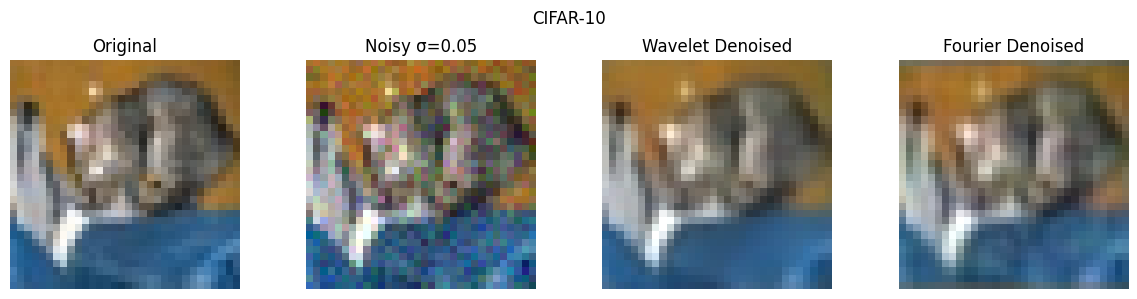

[CIFAR-10] Noise std 0.10: Wavelet MSE=0.0018, Fourier MSE=0.0022


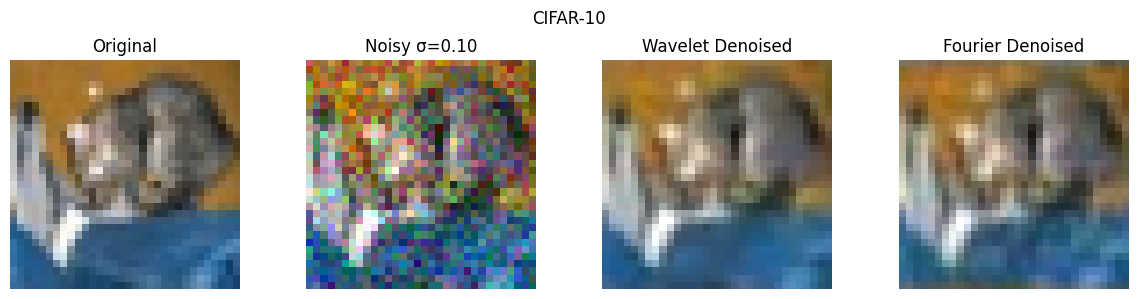

[CIFAR-10] Noise std 0.15: Wavelet MSE=0.0031, Fourier MSE=0.0038


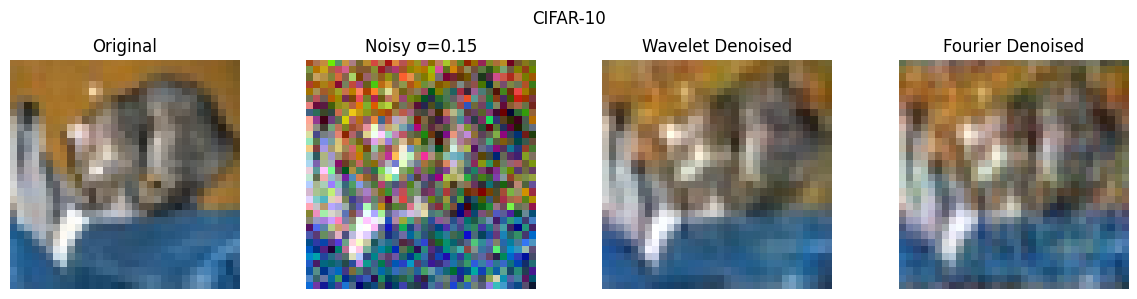

[CIFAR-10] Noise std 0.20: Wavelet MSE=0.0052, Fourier MSE=0.0064


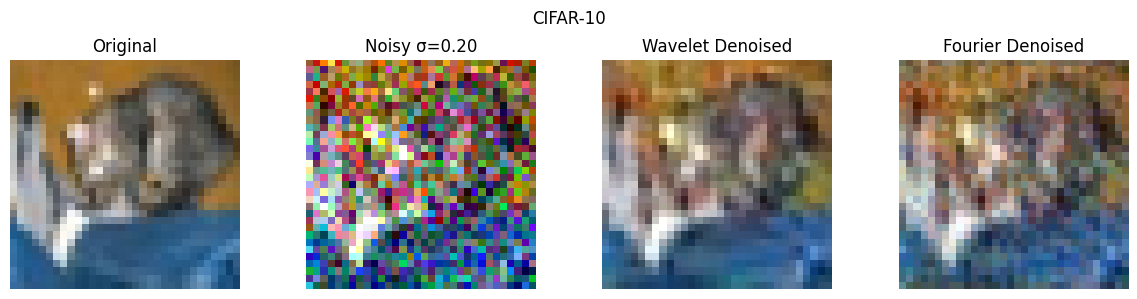

[CIFAR-10] Noise std 0.25: Wavelet MSE=0.0080, Fourier MSE=0.0100


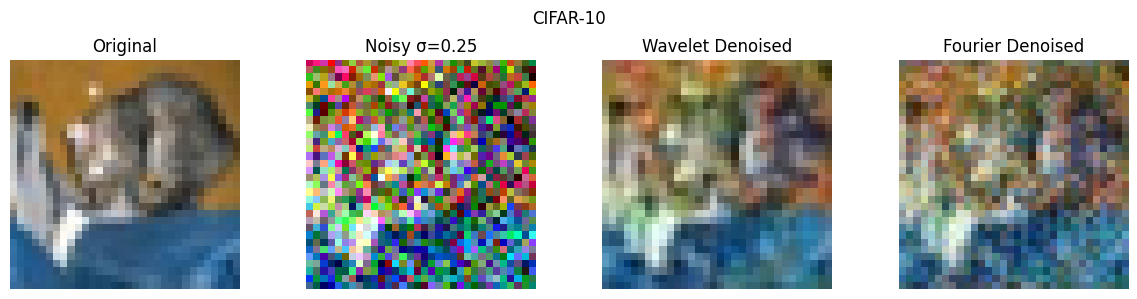


=== STL10 (96x96) Evaluation ===
[STL10] Noise std 0.05: Wavelet MSE=0.0013, Fourier MSE=0.0011


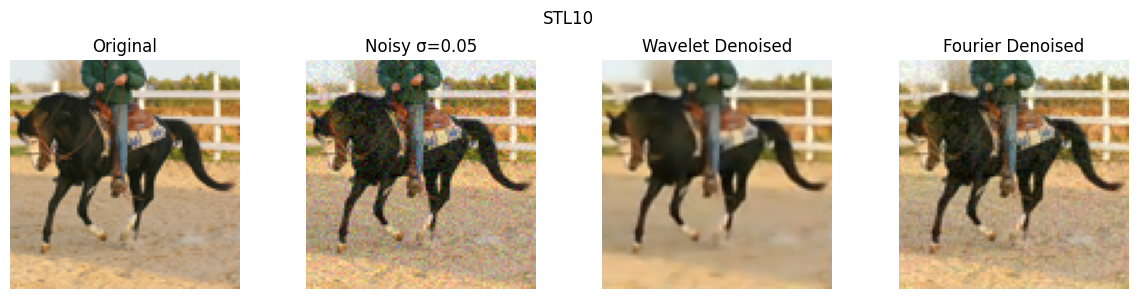

[STL10] Noise std 0.10: Wavelet MSE=0.0018, Fourier MSE=0.0033


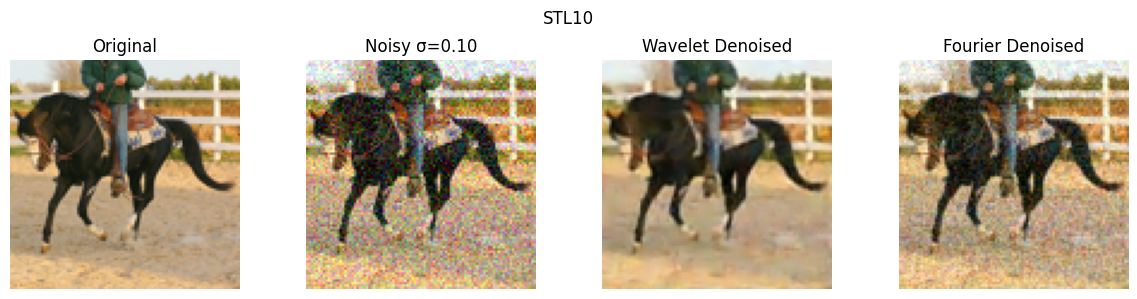

[STL10] Noise std 0.15: Wavelet MSE=0.0029, Fourier MSE=0.0072


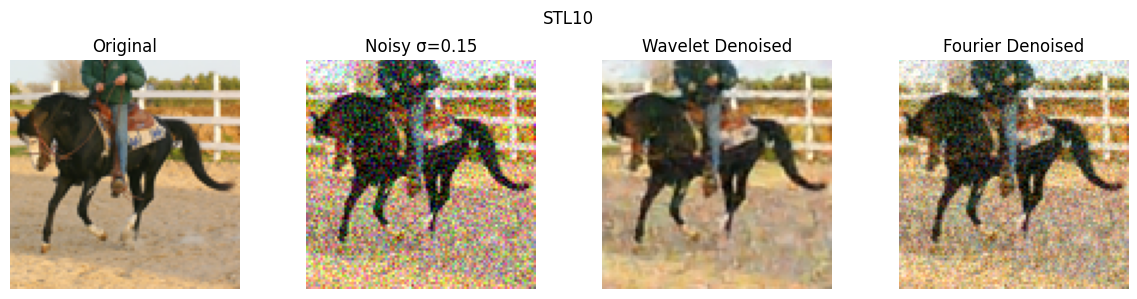

[STL10] Noise std 0.20: Wavelet MSE=0.0050, Fourier MSE=0.0125


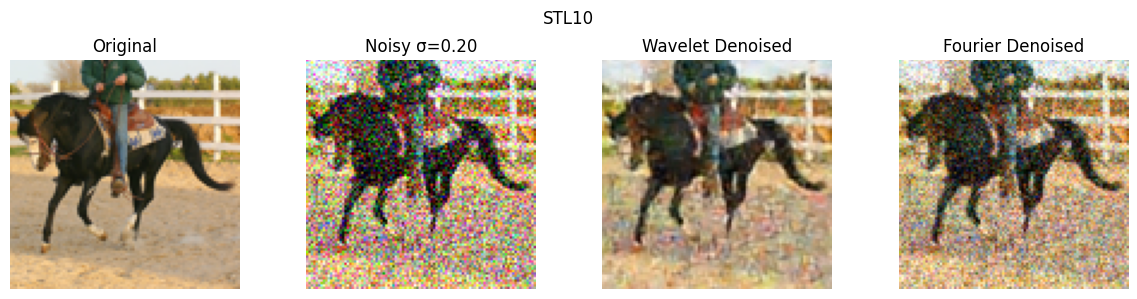

[STL10] Noise std 0.25: Wavelet MSE=0.0079, Fourier MSE=0.0189


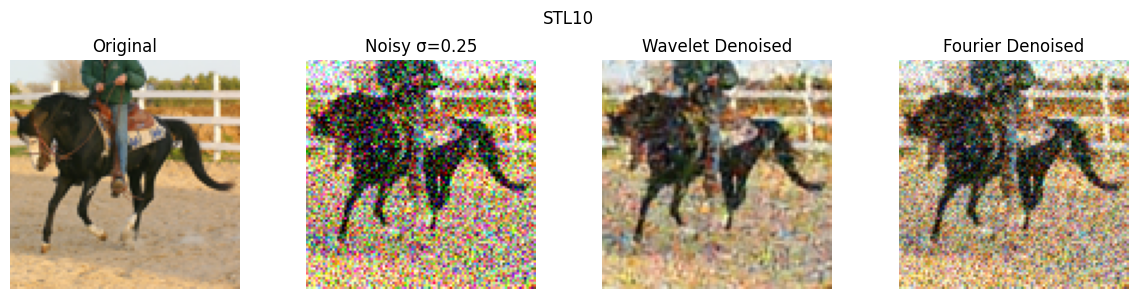

In [16]:
def evaluate_denoisers_on_loader(loader, name="Dataset"):
    wavelet_model.eval()
    fourier_model.eval()

    for std in noise_levels_test:
        imgs, _ = next(iter(loader))
        imgs = imgs.to(device)
        noisy_imgs = add_gaussian_noise(imgs, std=std)

        with torch.no_grad():
            LL, LH, HL, HH = haar_dwt2(noisy_imgs)
            wavelet_input = torch.cat([LL, LH, HL, HH], dim=1)
            wavelet_out = wavelet_model(wavelet_input)
            LL_out, LH_out, HL_out, HH_out = torch.split(wavelet_out, 3, dim=1)
            recon_wavelet = haar_idwt2(LL_out, LH_out, HL_out, HH_out).clamp(0, 1)

            X = fft2c(noisy_imgs)
            fourier_input = torch.cat([X.real, X.imag], dim=1)
            fourier_out = fourier_model(fourier_input)
            X_out = torch.complex(fourier_out[:, :3], fourier_out[:, 3:])
            recon_fourier = ifft2c(X_out).clamp(0, 1)

        wavelet_mse = nn.functional.mse_loss(recon_wavelet, imgs).item()
        fourier_mse = nn.functional.mse_loss(recon_fourier, imgs).item()
        print(f"[{name}] Noise std {std:.2f}: "
              f"Wavelet MSE={wavelet_mse:.4f}, Fourier MSE={fourier_mse:.4f}")

        fig, axes = plt.subplots(1, 4, figsize=(12, 3))
        axes[0].imshow(imgs[0].cpu().permute(1, 2, 0)); axes[0].set_title("Original"); axes[0].axis("off")
        axes[1].imshow(noisy_imgs[0].cpu().permute(1, 2, 0)); axes[1].set_title(f"Noisy σ={std:.2f}"); axes[1].axis("off")
        axes[2].imshow(recon_wavelet[0].cpu().permute(1, 2, 0)); axes[2].set_title("Wavelet Denoised"); axes[2].axis("off")
        axes[3].imshow(recon_fourier[0].cpu().permute(1, 2, 0)); axes[3].set_title("Fourier Denoised"); axes[3].axis("off")
        plt.suptitle(name)
        plt.tight_layout()
        plt.show()


print("\n=== CIFAR-10 (32x32) Evaluation ===")
evaluate_denoisers_on_loader(testloader, name="CIFAR-10")

print("\n=== STL10 (96x96) Evaluation ===")
evaluate_denoisers_on_loader(stl_testloader, name="STL10")


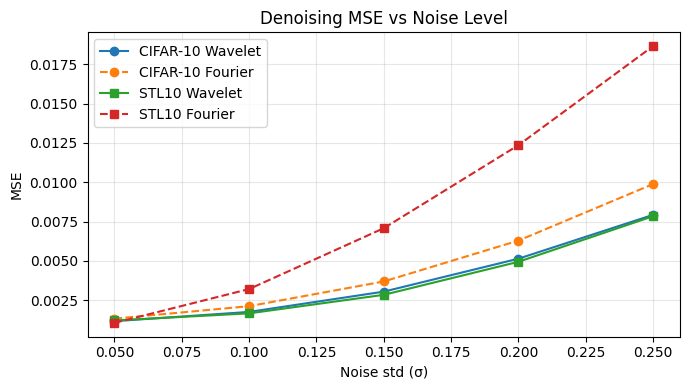

In [17]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

@torch.no_grad()
def _forward_wavelet(noisy):
    LL, LH, HL, HH = haar_dwt2(noisy)
    w_in = torch.cat([LL, LH, HL, HH], dim=1)
    w_out = wavelet_model(w_in)
    LLp, LHp, HLp, HHp = torch.split(w_out, 3, dim=1)
    return haar_idwt2(LLp, LHp, HLp, HHp).clamp(0, 1)

@torch.no_grad()
def _forward_fourier(noisy):
    X = fft2c(noisy)
    f_in = torch.cat([X.real, X.imag], dim=1)
    f_out = fourier_model(f_in)
    xr, xi = f_out[:, :3], f_out[:, 3:]
    return ifft2c(torch.complex(xr, xi)).clamp(0, 1)

@torch.no_grad()
def _mse_curve(loader, sigmas):
    wavelet_model.eval(); fourier_model.eval()
    w_vals, f_vals = [], []
    for s in sigmas:
        w_sum = f_sum = 0.0
        npx = 0
        for imgs, _ in loader:
            imgs = imgs.to(device)
            noisy = add_gaussian_noise(imgs, std=float(s))
            rw = _forward_wavelet(noisy)
            rf = _forward_fourier(noisy)
            w_sum += F.mse_loss(rw, imgs, reduction="sum").item()
            f_sum += F.mse_loss(rf, imgs, reduction="sum").item()
            npx += imgs.numel()
        w_vals.append(w_sum / npx)
        f_vals.append(f_sum / npx)
    return np.array(w_vals), np.array(f_vals)

sigmas = [0.05, 0.10, 0.15, 0.20, 0.25]
cifar_w, cifar_f = _mse_curve(testloader, sigmas)
stl_w, stl_f     = _mse_curve(stl_testloader, sigmas)

plt.figure(figsize=(7,4))
plt.plot(sigmas, cifar_w, marker='o', label='CIFAR-10 Wavelet')
plt.plot(sigmas, cifar_f, marker='o', linestyle='--', label='CIFAR-10 Fourier')
plt.plot(sigmas, stl_w, marker='s', label='STL10 Wavelet')
plt.plot(sigmas, stl_f, marker='s', linestyle='--', label='STL10 Fourier')
plt.title('Denoising MSE vs Noise Level')
plt.xlabel('Noise std (σ)')
plt.ylabel('MSE')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


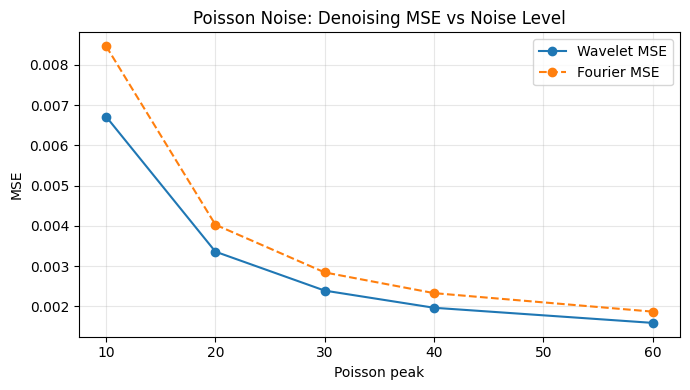

In [18]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def _poisson_noise(imgs, peak):
    x = imgs.clamp(0, 1)
    return torch.poisson(x * peak) / peak

@torch.no_grad()
def _poisson_mse_curve(loader, peaks):
    wavelet_model.eval(); fourier_model.eval()
    w_vals, f_vals = [], []
    for p in peaks:
        w_sum = f_sum = 0.0
        npx = 0
        for imgs, _ in loader:
            imgs = imgs.to(device)
            noisy = _poisson_noise(imgs, float(p))
            rw = _forward_wavelet(noisy)
            rf = _forward_fourier(noisy)
            w_sum += F.mse_loss(rw, imgs, reduction="sum").item()
            f_sum += F.mse_loss(rf, imgs, reduction="sum").item()
            npx += imgs.numel()
        w_vals.append(w_sum / npx)
        f_vals.append(f_sum / npx)
    return np.array(w_vals), np.array(f_vals)

peaks = [60, 40, 30, 20, 10]
pw, pf = _poisson_mse_curve(testloader, peaks)

plt.figure(figsize=(7,4))
plt.plot(peaks, pw, marker='o', label='Wavelet MSE')
plt.plot(peaks, pf, marker='o', linestyle='--', label='Fourier MSE')
plt.title('Poisson Noise: Denoising MSE vs Noise Level')
plt.xlabel('Poisson peak')
plt.ylabel('MSE')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


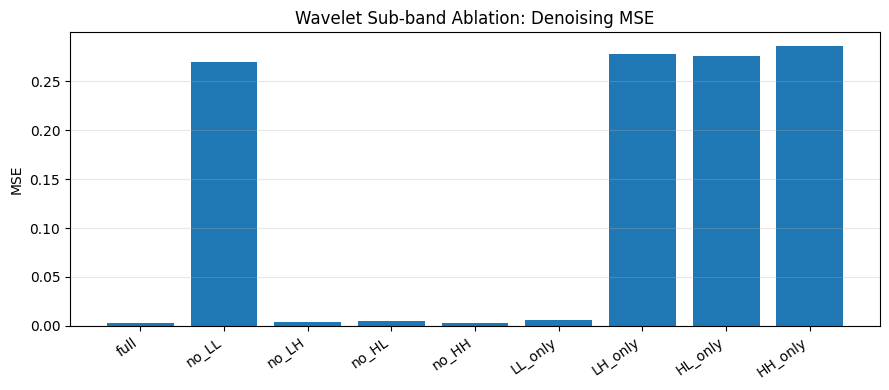

In [19]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

@torch.no_grad()
def _subband_ablation_mse(loader, std=0.15):
    wavelet_model.eval()
    sums = {k: 0.0 for k in ["full","no_LL","no_LH","no_HL","no_HH","LL_only","LH_only","HL_only","HH_only"]}
    npx = 0
    for imgs, _ in loader:
        imgs = imgs.to(device)
        noisy = add_gaussian_noise(imgs, std=float(std))
        LL, LH, HL, HH = haar_dwt2(noisy)
        w_in = torch.cat([LL, LH, HL, HH], dim=1)
        w_out = wavelet_model(w_in)
        LLp, LHp, HLp, HHp = torch.split(w_out, 3, dim=1)
        z = torch.zeros_like(LLp)

        rec = {
            "full":    haar_idwt2(LLp, LHp, HLp, HHp).clamp(0,1),
            "no_LL":   haar_idwt2(z,   LHp, HLp, HHp).clamp(0,1),
            "no_LH":   haar_idwt2(LLp, z,   HLp, HHp).clamp(0,1),
            "no_HL":   haar_idwt2(LLp, LHp, z,   HHp).clamp(0,1),
            "no_HH":   haar_idwt2(LLp, LHp, HLp, z  ).clamp(0,1),
            "LL_only": haar_idwt2(LLp, z,   z,   z  ).clamp(0,1),
            "LH_only": haar_idwt2(z,   LHp, z,   z  ).clamp(0,1),
            "HL_only": haar_idwt2(z,   z,   HLp, z  ).clamp(0,1),
            "HH_only": haar_idwt2(z,   z,   z,   HHp).clamp(0,1),
        }

        for k in sums:
            sums[k] += F.mse_loss(rec[k], imgs, reduction="sum").item()
        npx += imgs.numel()

    return {k: sums[k] / npx for k in sums}

ab = _subband_ablation_mse(testloader, std=0.15)
labels = ["full","no_LL","no_LH","no_HL","no_HH","LL_only","LH_only","HL_only","HH_only"]
vals = [ab[k] for k in labels]

plt.figure(figsize=(9,4))
plt.bar(range(len(labels)), vals)
plt.title('Wavelet Sub-band Ablation: Denoising MSE')
plt.ylabel('MSE')
plt.xticks(range(len(labels)), labels, rotation=35, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
